In [34]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy.fftpack

In [35]:
class DNN(torch.nn.Module):
    def __init__(self, input_dim, output_dim, width, depth, activation):
        super(DNN, self).__init__()
        self.input = torch.nn.Linear(input_dim, width)
        self.hidden = torch.nn.ModuleList([torch.nn.Linear(width, width) for i in range(depth-1)])
        self.output = torch.nn.Linear(width, output_dim)
        self.act = activation
        
    def init_weights(self):
        min_, max_ = -1, 1
        torch.nn.init.uniform_(self.input.weight, min_, max_)
        torch.nn.init.uniform_(self.input.bias, min_, max_)
        for layer in self.hidden:
            torch.nn.init.uniform_(layer.weight, min_, max_)
            torch.nn.init.uniform_(layer.bias, min_, max_)
        torch.nn.init.uniform_(self.output.weight, min_, max_)
        torch.nn.init.uniform_(self.output.bias, min_, max_)
    
    def forward(self, x):
        x = self.act(self.input(x))
        for layer in self.hidden:
            x = self.act(layer(x))
        x = self.output(x)
        return x

In [36]:
theta = np.linspace(-np.pi, np.pi, 1024)
x = np.cos(theta)
x = torch.tensor(x, dtype=torch.float32).reshape(-1,1)

In [37]:
width_list = [10,15,20,25]
depth_list = [10,15,20,25]

In [38]:
def compute_num_params(input_dim, output_dim, width, depth):
    num = input_dim*(width-1)+output_dim*width+(depth-2)*width*(width-1)
    return num

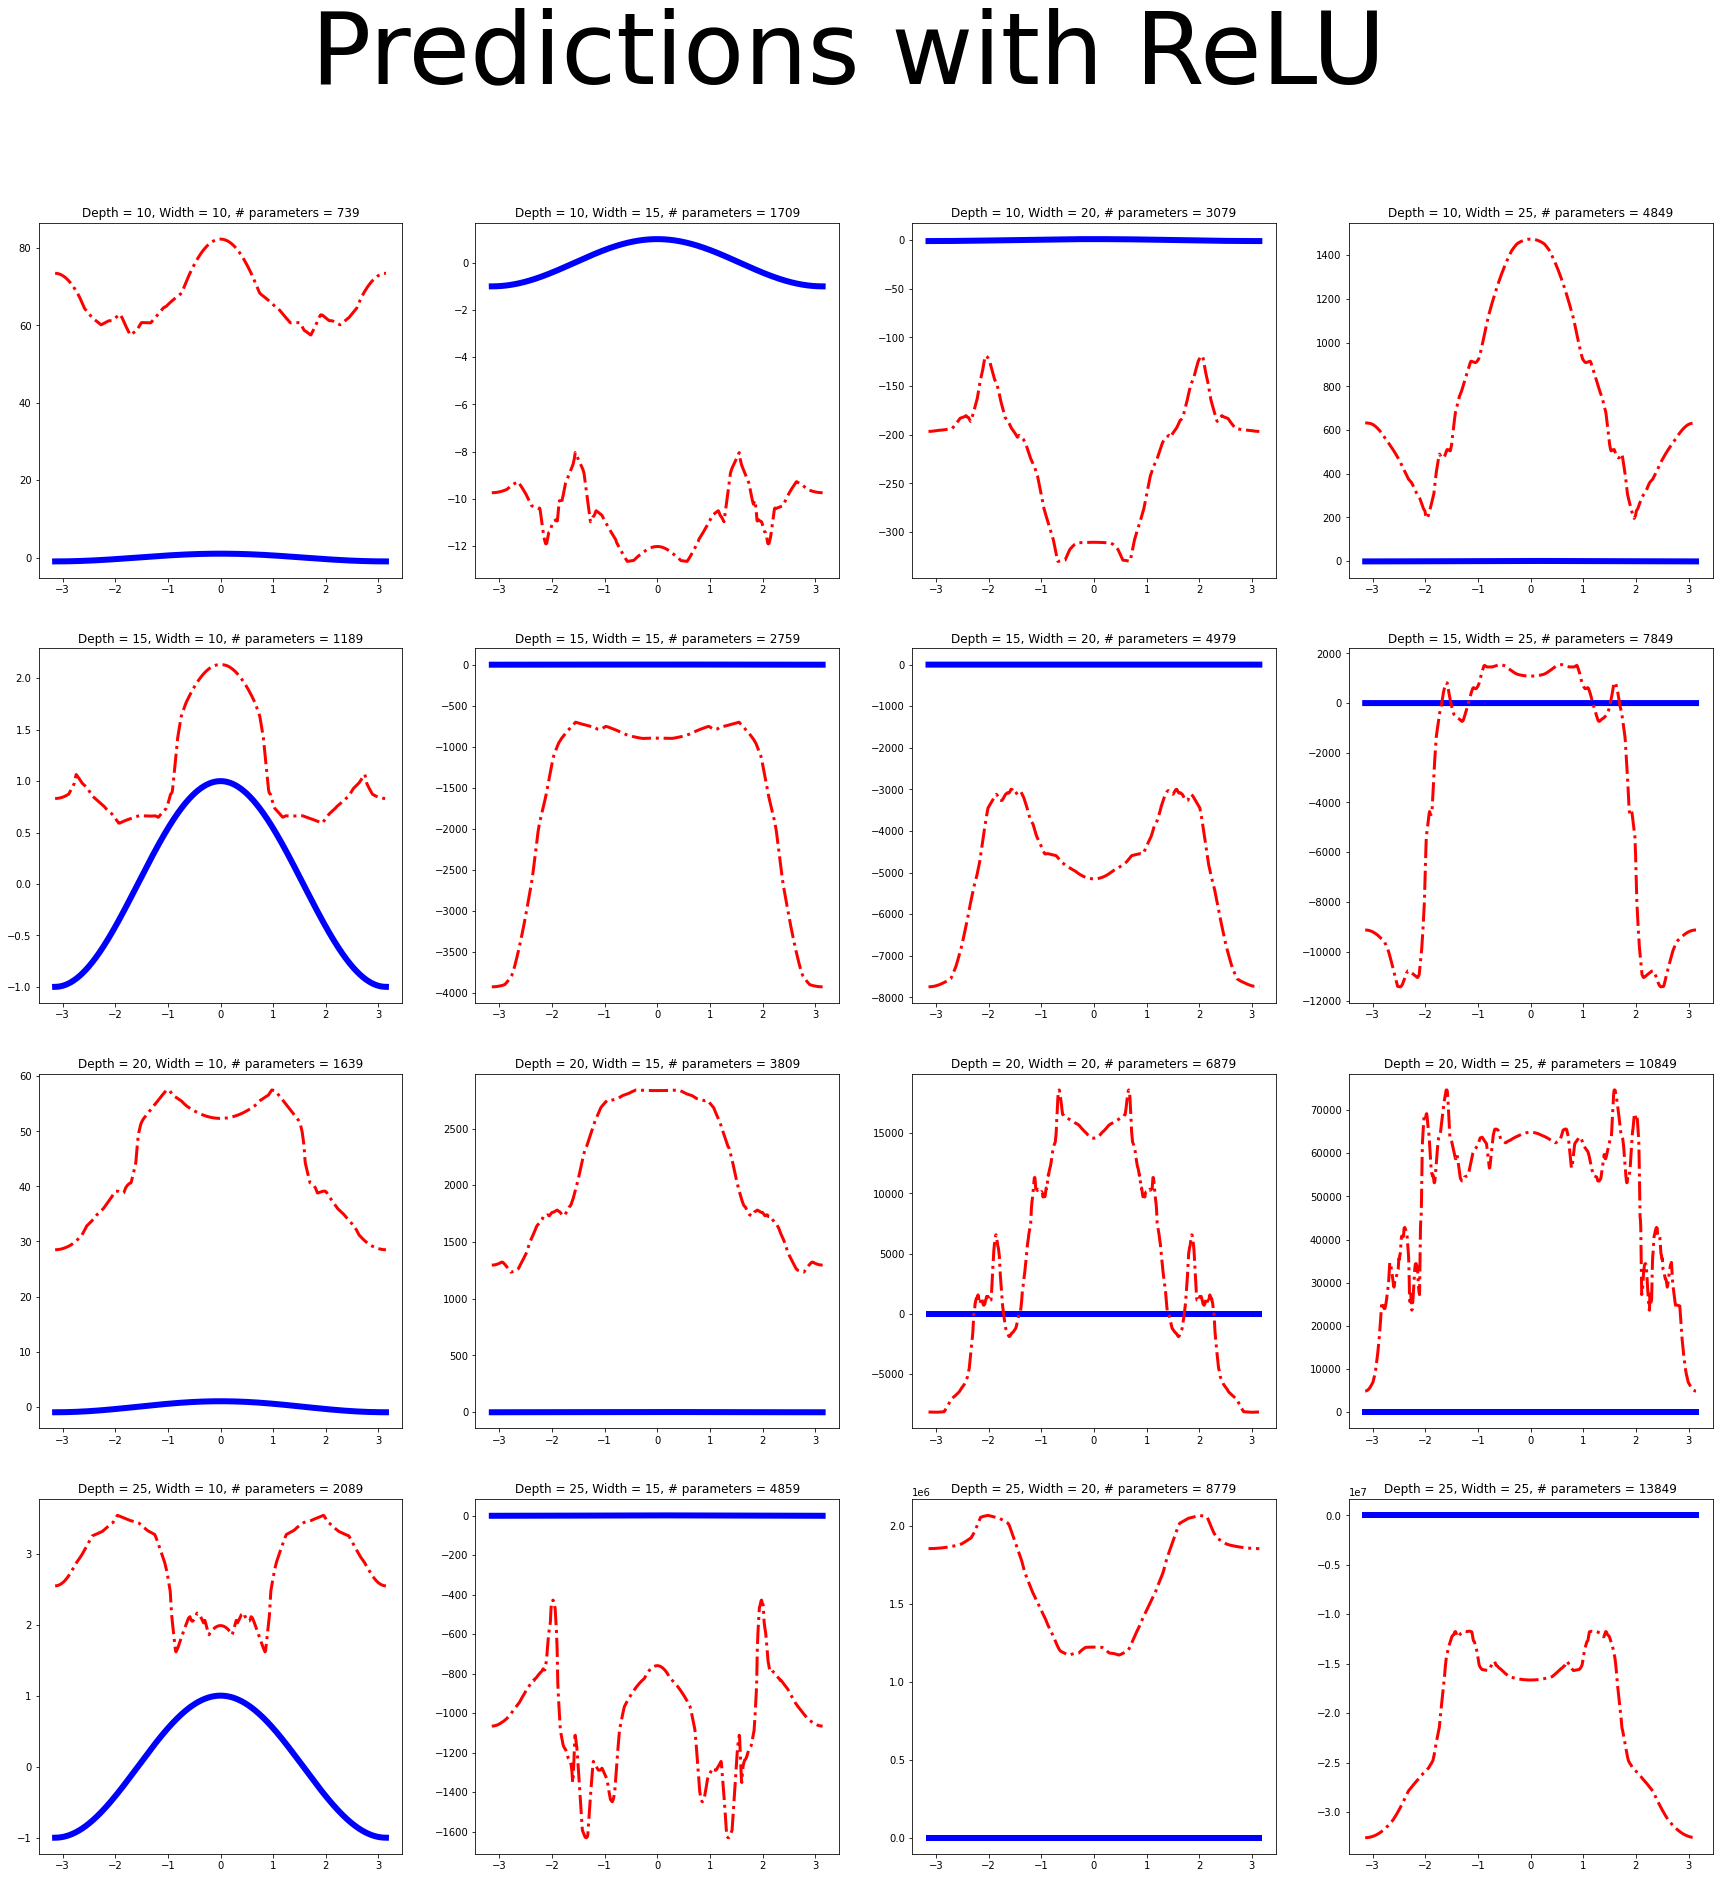

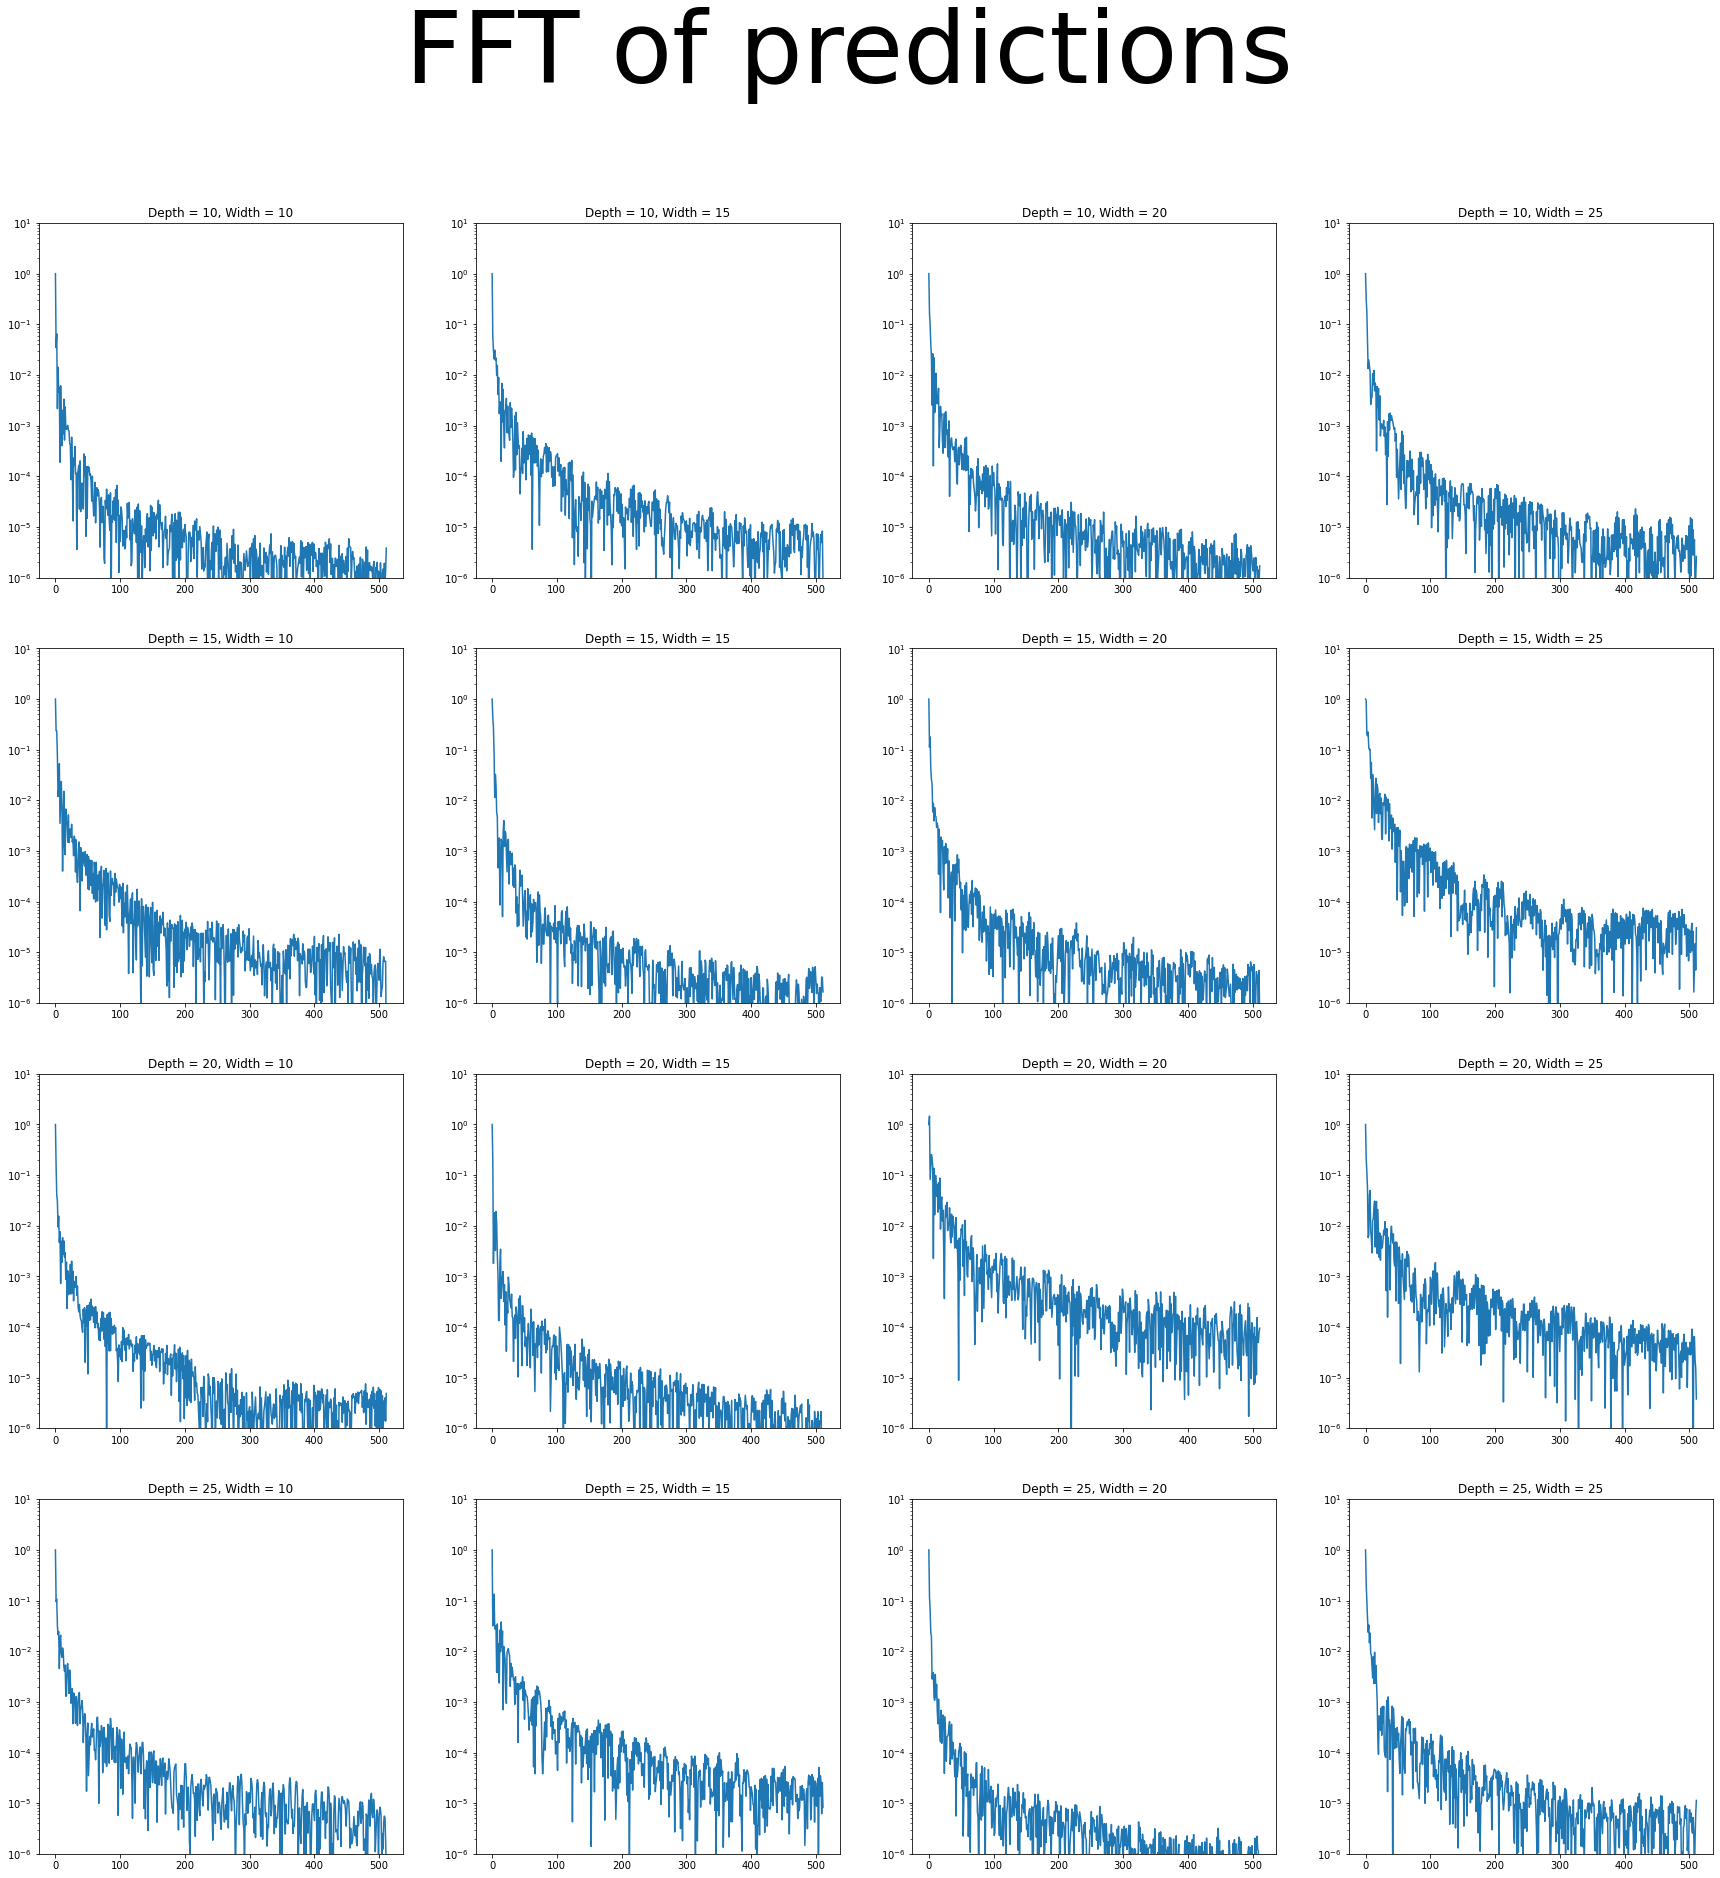

In [39]:
fig1, axs1 = plt.subplots(4, 4, figsize=(30,30))
fig2, axs2 = plt.subplots(4, 4, figsize=(30,30))

fig1.suptitle('Predictions with ReLU', fontsize=100)
fig2.suptitle('FFT of predictions', fontsize=100)

for i, width in enumerate(width_list):
    for j, depth in enumerate(depth_list):
        
        input_dim = 1
        output_dim = 1

        model = DNN(input_dim=input_dim, output_dim=output_dim, width=width, depth=depth, activation=torch.nn.ReLU())
        model.init_weights()

        with torch.no_grad():
            y_pred = model(x).flatten()
                    
        total_params = compute_num_params(1, 1, width, depth)
        axs1[j, i].plot(theta, x, "b", linewidth=6, label='Actual')
        axs1[j, i].plot(theta, y_pred, "-.", linewidth=3, color="red", label='Predicted')
        axs1[j, i].set_title('Depth = {}, Width = {}, # parameters = {}'.format(depth, width, total_params))
        
        N = len(y_pred)
        yf = np.fft.fft(np.array(y_pred))
        axs2[j, i].plot(np.abs(yf[:N//2])/np.abs(yf[0]))
        axs2[j, i].set_yscale('log')
        axs2[j, i].set_ylim((10**-6,10**1))
        axs2[j, i].set_title('Depth = {}, Width = {}'.format(depth, width))
        
plt.show()

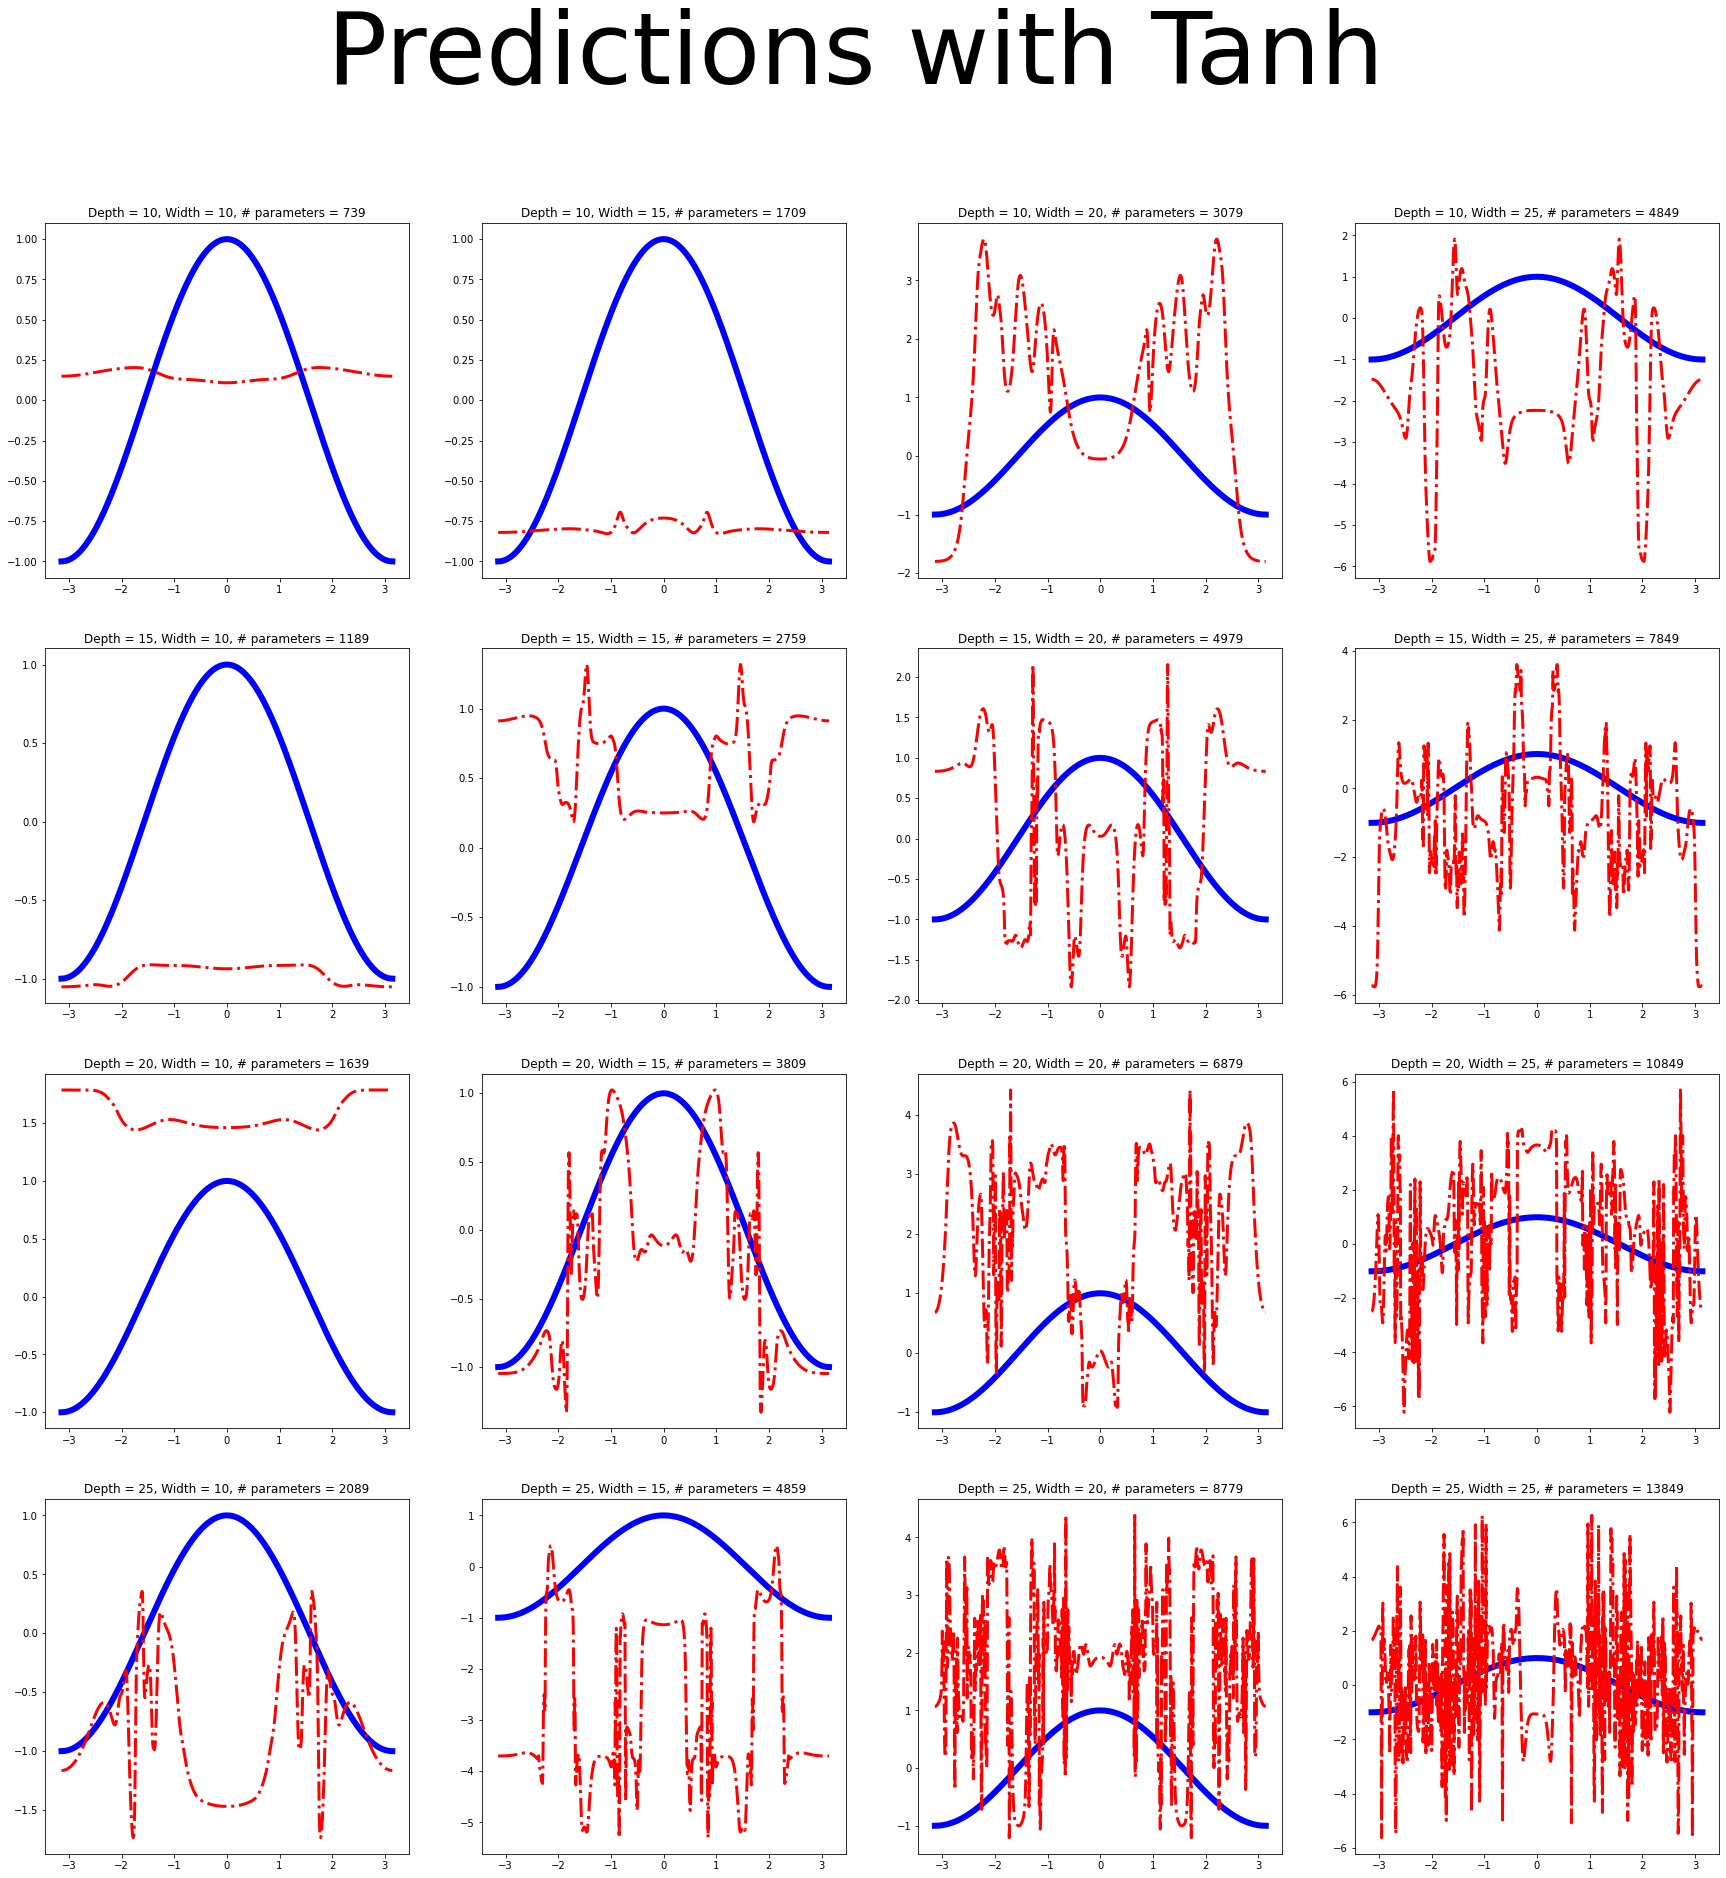

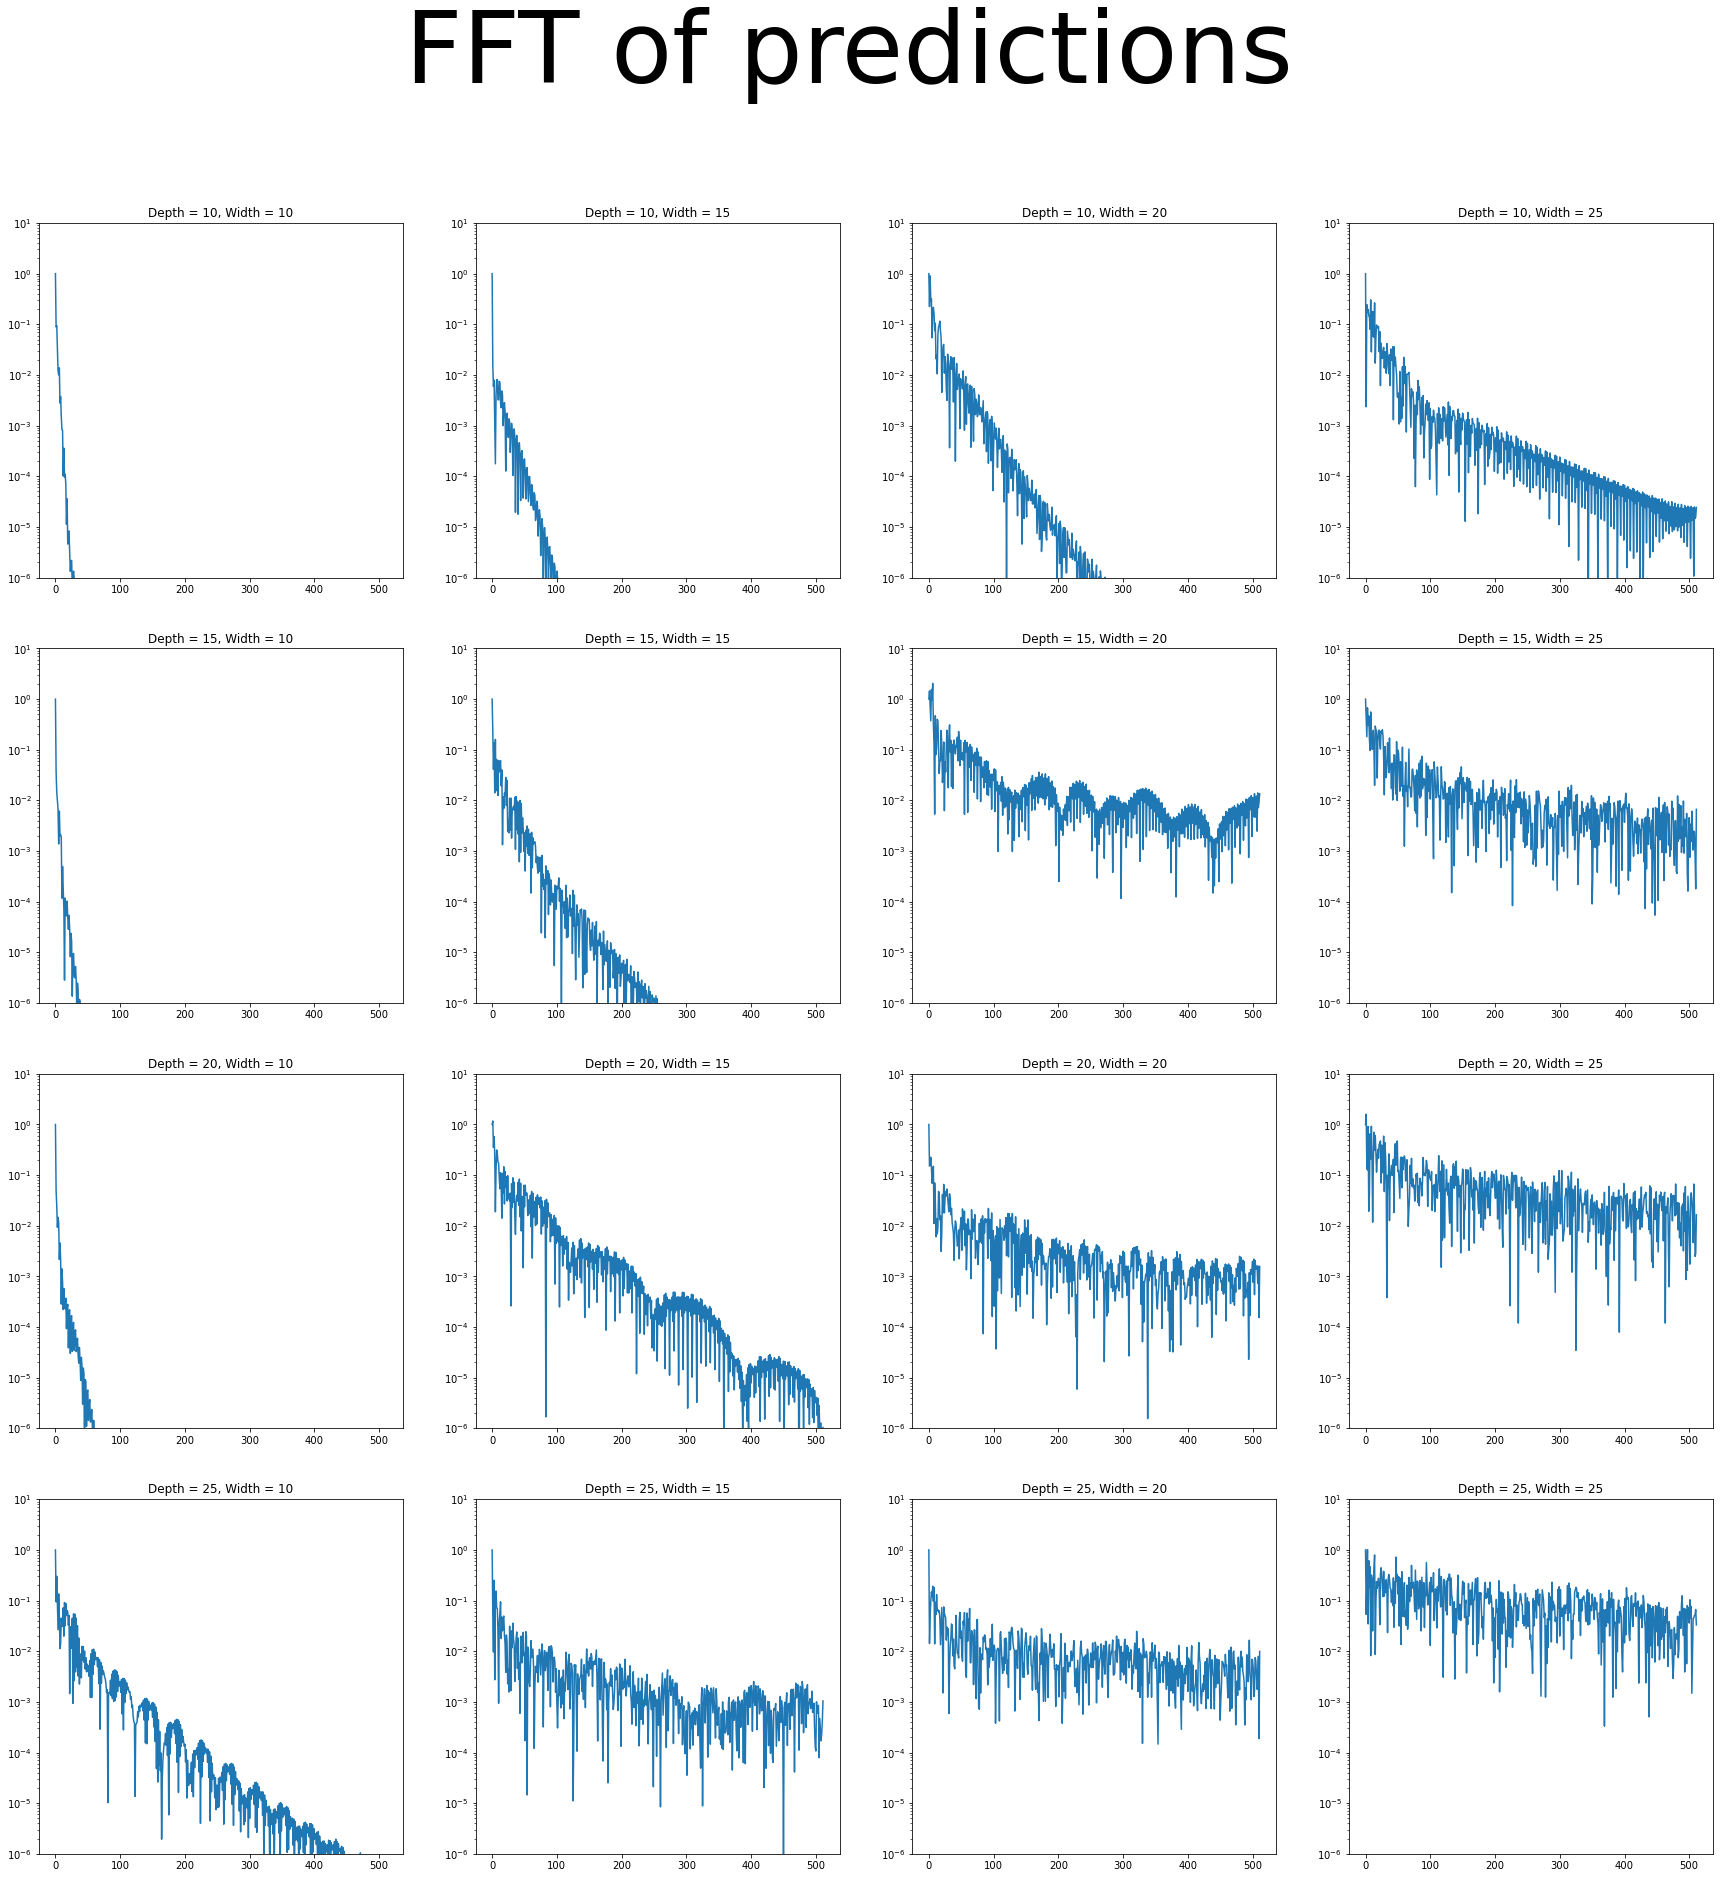

In [40]:
fig1, axs1 = plt.subplots(4, 4, figsize=(30,30))
fig2, axs2 = plt.subplots(4, 4, figsize=(30,30))

fig1.suptitle('Predictions with Tanh', fontsize=100)
fig2.suptitle('FFT of predictions', fontsize=100)

for i, width in enumerate(width_list):
    for j, depth in enumerate(depth_list):

        model = DNN(input_dim=1, output_dim=1, width=width, depth=depth, activation=torch.nn.Tanh())
        model.init_weights()

        with torch.no_grad():
            y_pred = model(x).flatten()
                    
        total_params = compute_num_params(1, 1, width, depth)
        axs1[j, i].plot(theta, x, "b", linewidth=6, label='Actual')
        axs1[j, i].plot(theta, y_pred, "-.", linewidth=3, color="red", label='Predicted')
        axs1[j, i].set_title('Depth = {}, Width = {}, # parameters = {}'.format(depth, width, total_params))
        
        N = len(y_pred)
        yf = np.fft.fft(np.array(y_pred))
        axs2[j, i].plot(np.abs(yf[:N//2])/np.abs(yf[0]))
        axs2[j, i].set_yscale('log')
        axs2[j, i].set_ylim((10**-6,10**1))
        axs2[j, i].set_title('Depth = {}, Width = {}'.format(depth, width))
        
plt.show()

# Observations about choice width and depth

It can be seen from the above plots of the Fourier transforms that the results differ for different values of the DNN width and depth. Both the width and the depth influence the decay of the Fourier transform. The wider and the deeper the neural network is, the more it tends to over-fit the data, which should be avoided. Overfiting can be spotted when looking at the FFT since the Fourier spectrum of an over-fitted model decays very slowly. On the other hand, if the model under-fits the data, the Fourier transform decreases extremely fast. The objective is too find the right balance to have the best possible model. To summarize, both a large width and a large network depth cause the FFT to decrease slowly (> leads to over-fitting).

# Observations about choice of activation function

It can be seen from the above plots that $ReLU()$ is less affected by the width and depth of the neural network than $Tanh()$. Indeed, the $ReLU()$ results appear to be more consistent across the FFT plot grid. I also notice that the $Tanh()$ approximation is always more in the range of the $cos(\theta)$ function than the $ReLU()$ approximation is.

# Trends variation when re-running script + cause

Some of the trends tend to be inconsistent when re-running the script. This is probably due to the fact that the parameters (weights and biases) are $\textbf{randomly}$ initialized according to a uniform distribution [-1, 1], differently for each instantiation of the DNN with different values of width and depth. This leads to inconsistency in some of the observed trends. Nevertheless, some of the trends are persistent. For example, the $Tanh()$ approximation is always more in the range of the $cos(\theta)$ function than the $ReLU()$ approximation is. Also, the trend that $Tanh()$ has more high-frequency oscillations than $ReLU()$ is consistent. Furthermore, increasing the width and depth consistently adds more oscillations in the approximations. However the quality of the approximations is variant with random initialization, and thus varies when re-running the scripts multiple times.

# Conclusion

A DNN is defined by a choice of architecture for it. The architecure includes the width and the depth of the network, and the activation function applied at each neuron. The good choice of architecture is at the intersection between engineering, science and art. Depending on the application, different architectures can be better suited. There is no golden rule for an architecture choice. What is important is to find ways to evaluate the model performance (e.g. plot the loss function at each iteration, FFT plot) to prevent under/over-fitting. That said, it is thus a hard task to choose the best width, depth and activation function for a neural network that prevent over/under-fitting but represent the data well at the same time.

# Different choices of a for parameters ~ U(-a,a)

In [41]:
class DNN2(torch.nn.Module):
    def __init__(self, input_dim, output_dim, width, depth, activation, param_range):
        super(DNN2, self).__init__()
        self.input = torch.nn.Linear(input_dim, width)
        self.hidden = torch.nn.ModuleList([torch.nn.Linear(width, width) for i in range(depth-1)])
        self.output = torch.nn.Linear(width, output_dim)
        self.act = activation
        self.range = param_range
        
    def init_weights(self):
        min_, max_ = -self.range, self.range
        torch.nn.init.uniform_(self.input.weight, min_, max_)
        torch.nn.init.uniform_(self.input.bias, min_, max_)
        for layer in self.hidden:
            torch.nn.init.uniform_(layer.weight, min_, max_)
            torch.nn.init.uniform_(layer.bias, min_, max_)
        torch.nn.init.uniform_(self.output.weight, min_, max_)
        torch.nn.init.uniform_(self.output.bias, min_, max_)
    
    def forward(self, x):
        x = self.act(self.input(x))
        for layer in self.hidden:
            x = self.act(layer(x))
        x = self.output(x)
        return x

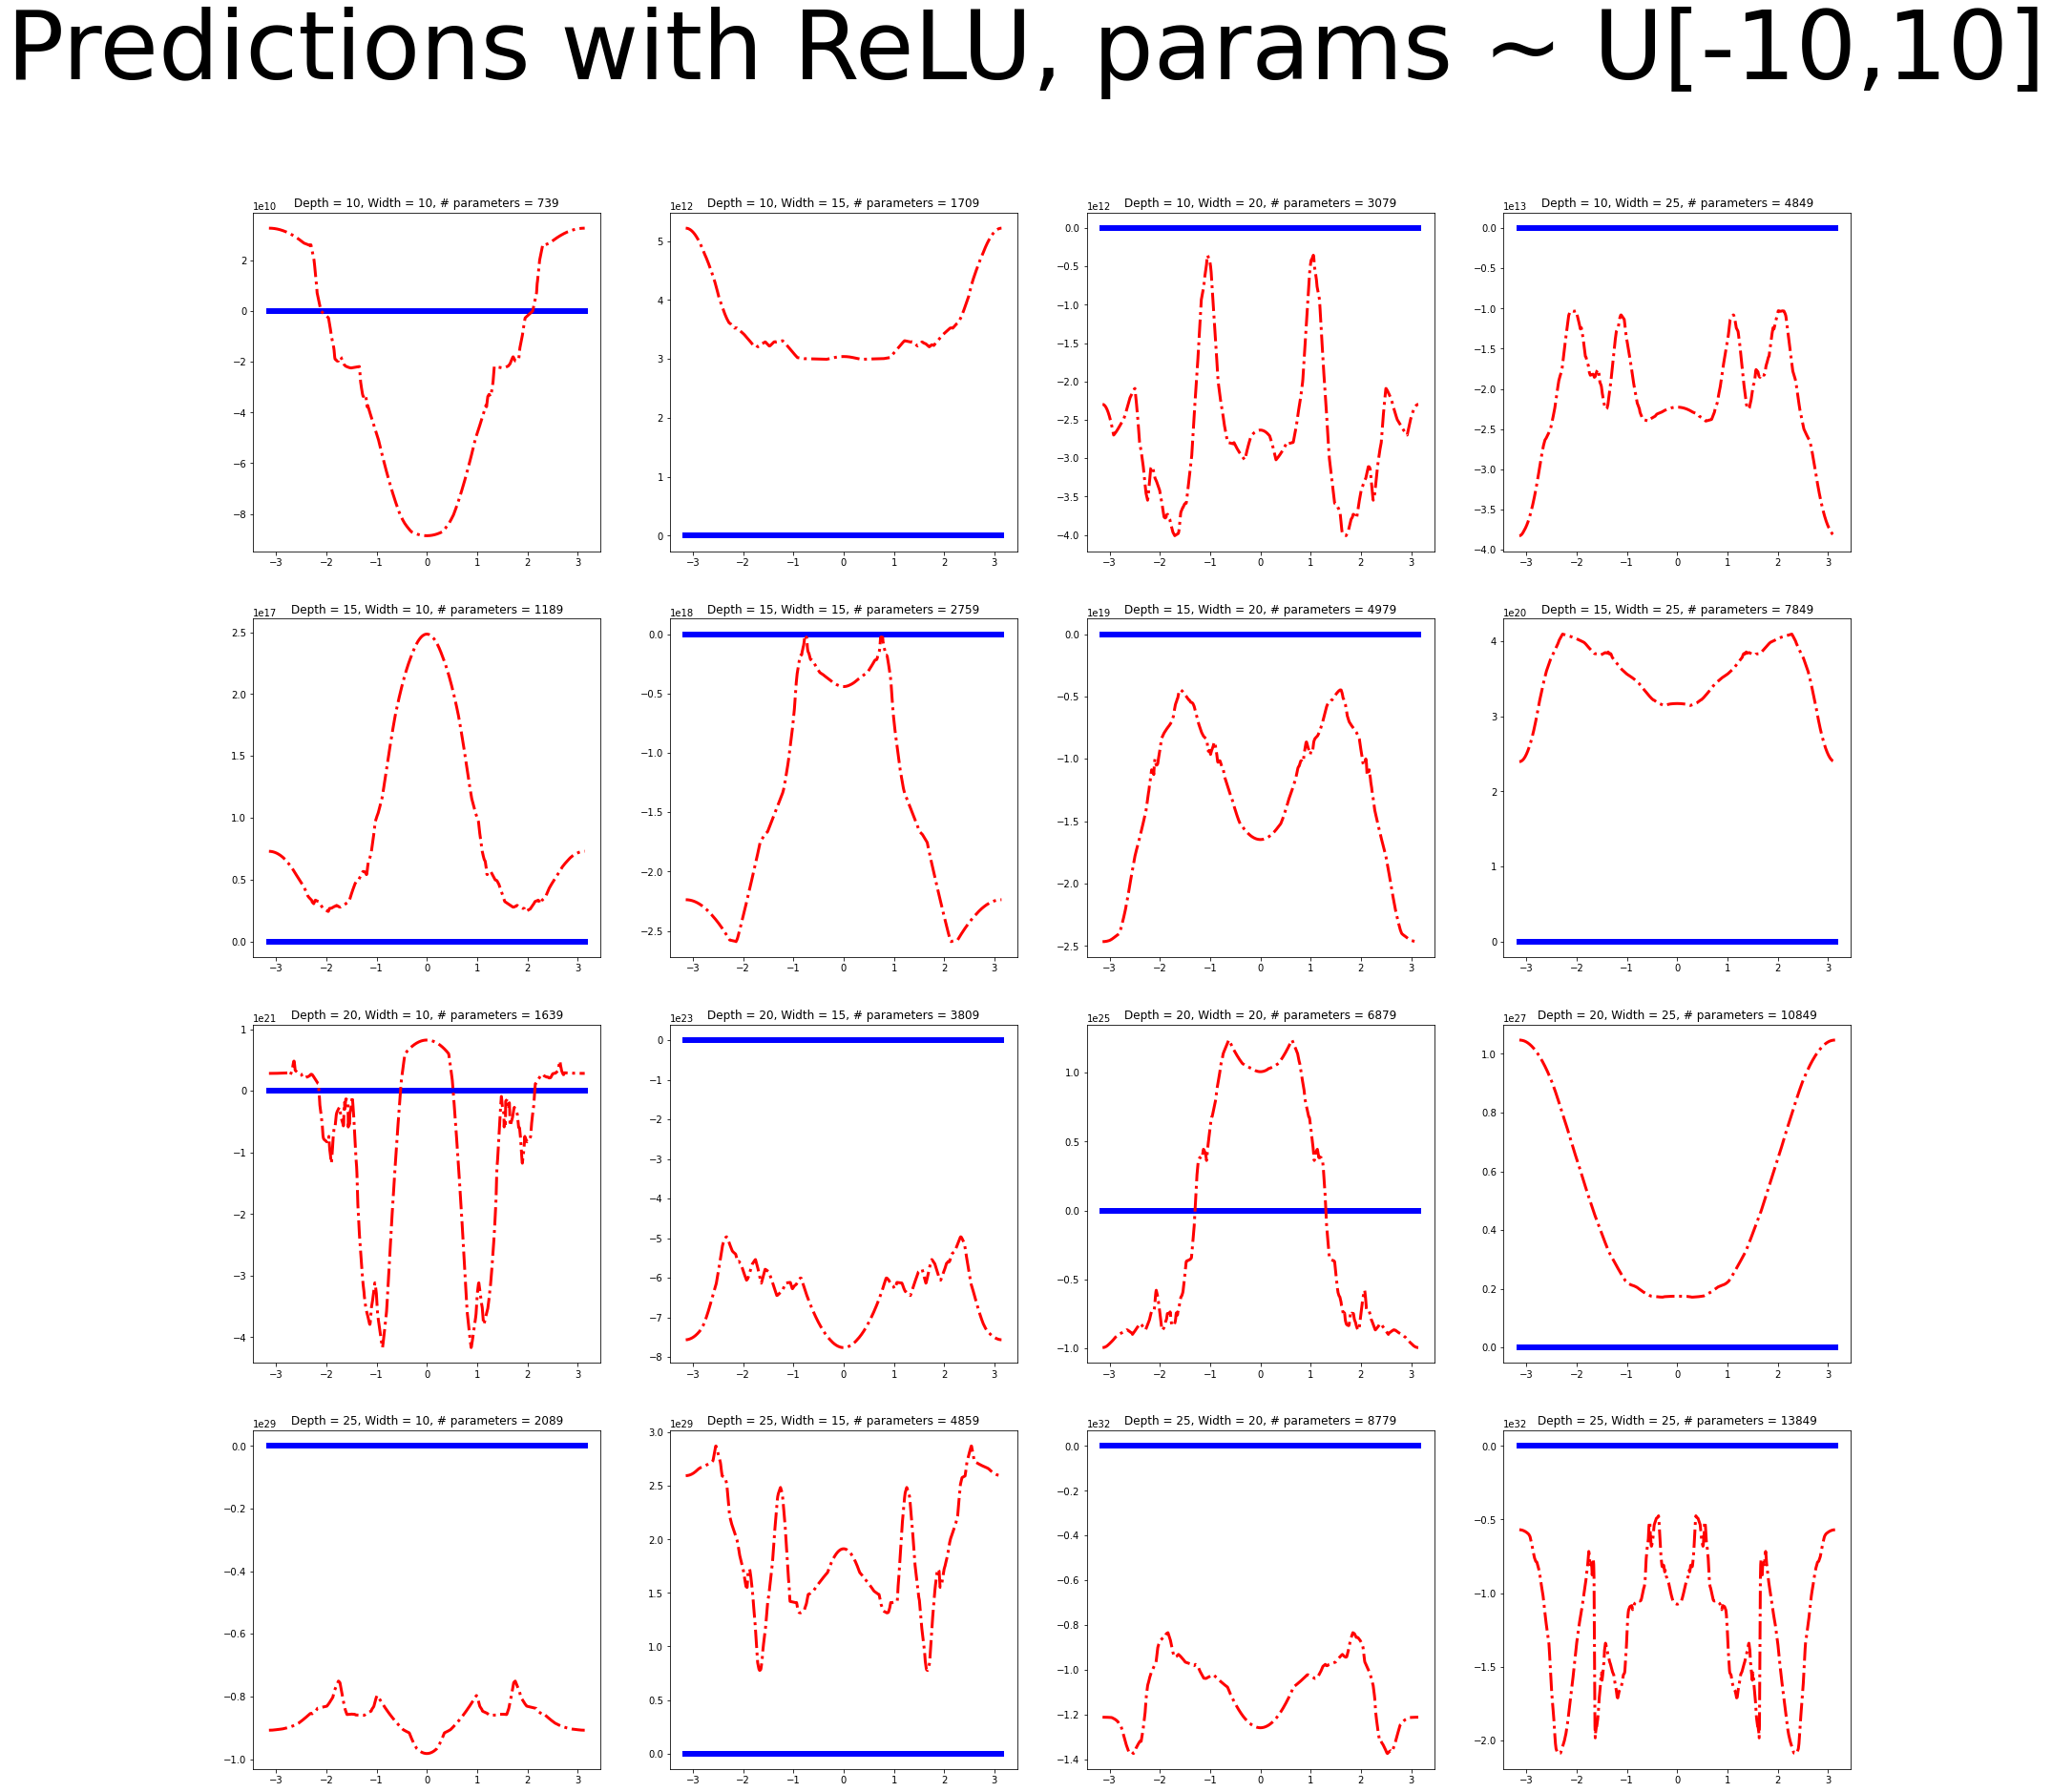

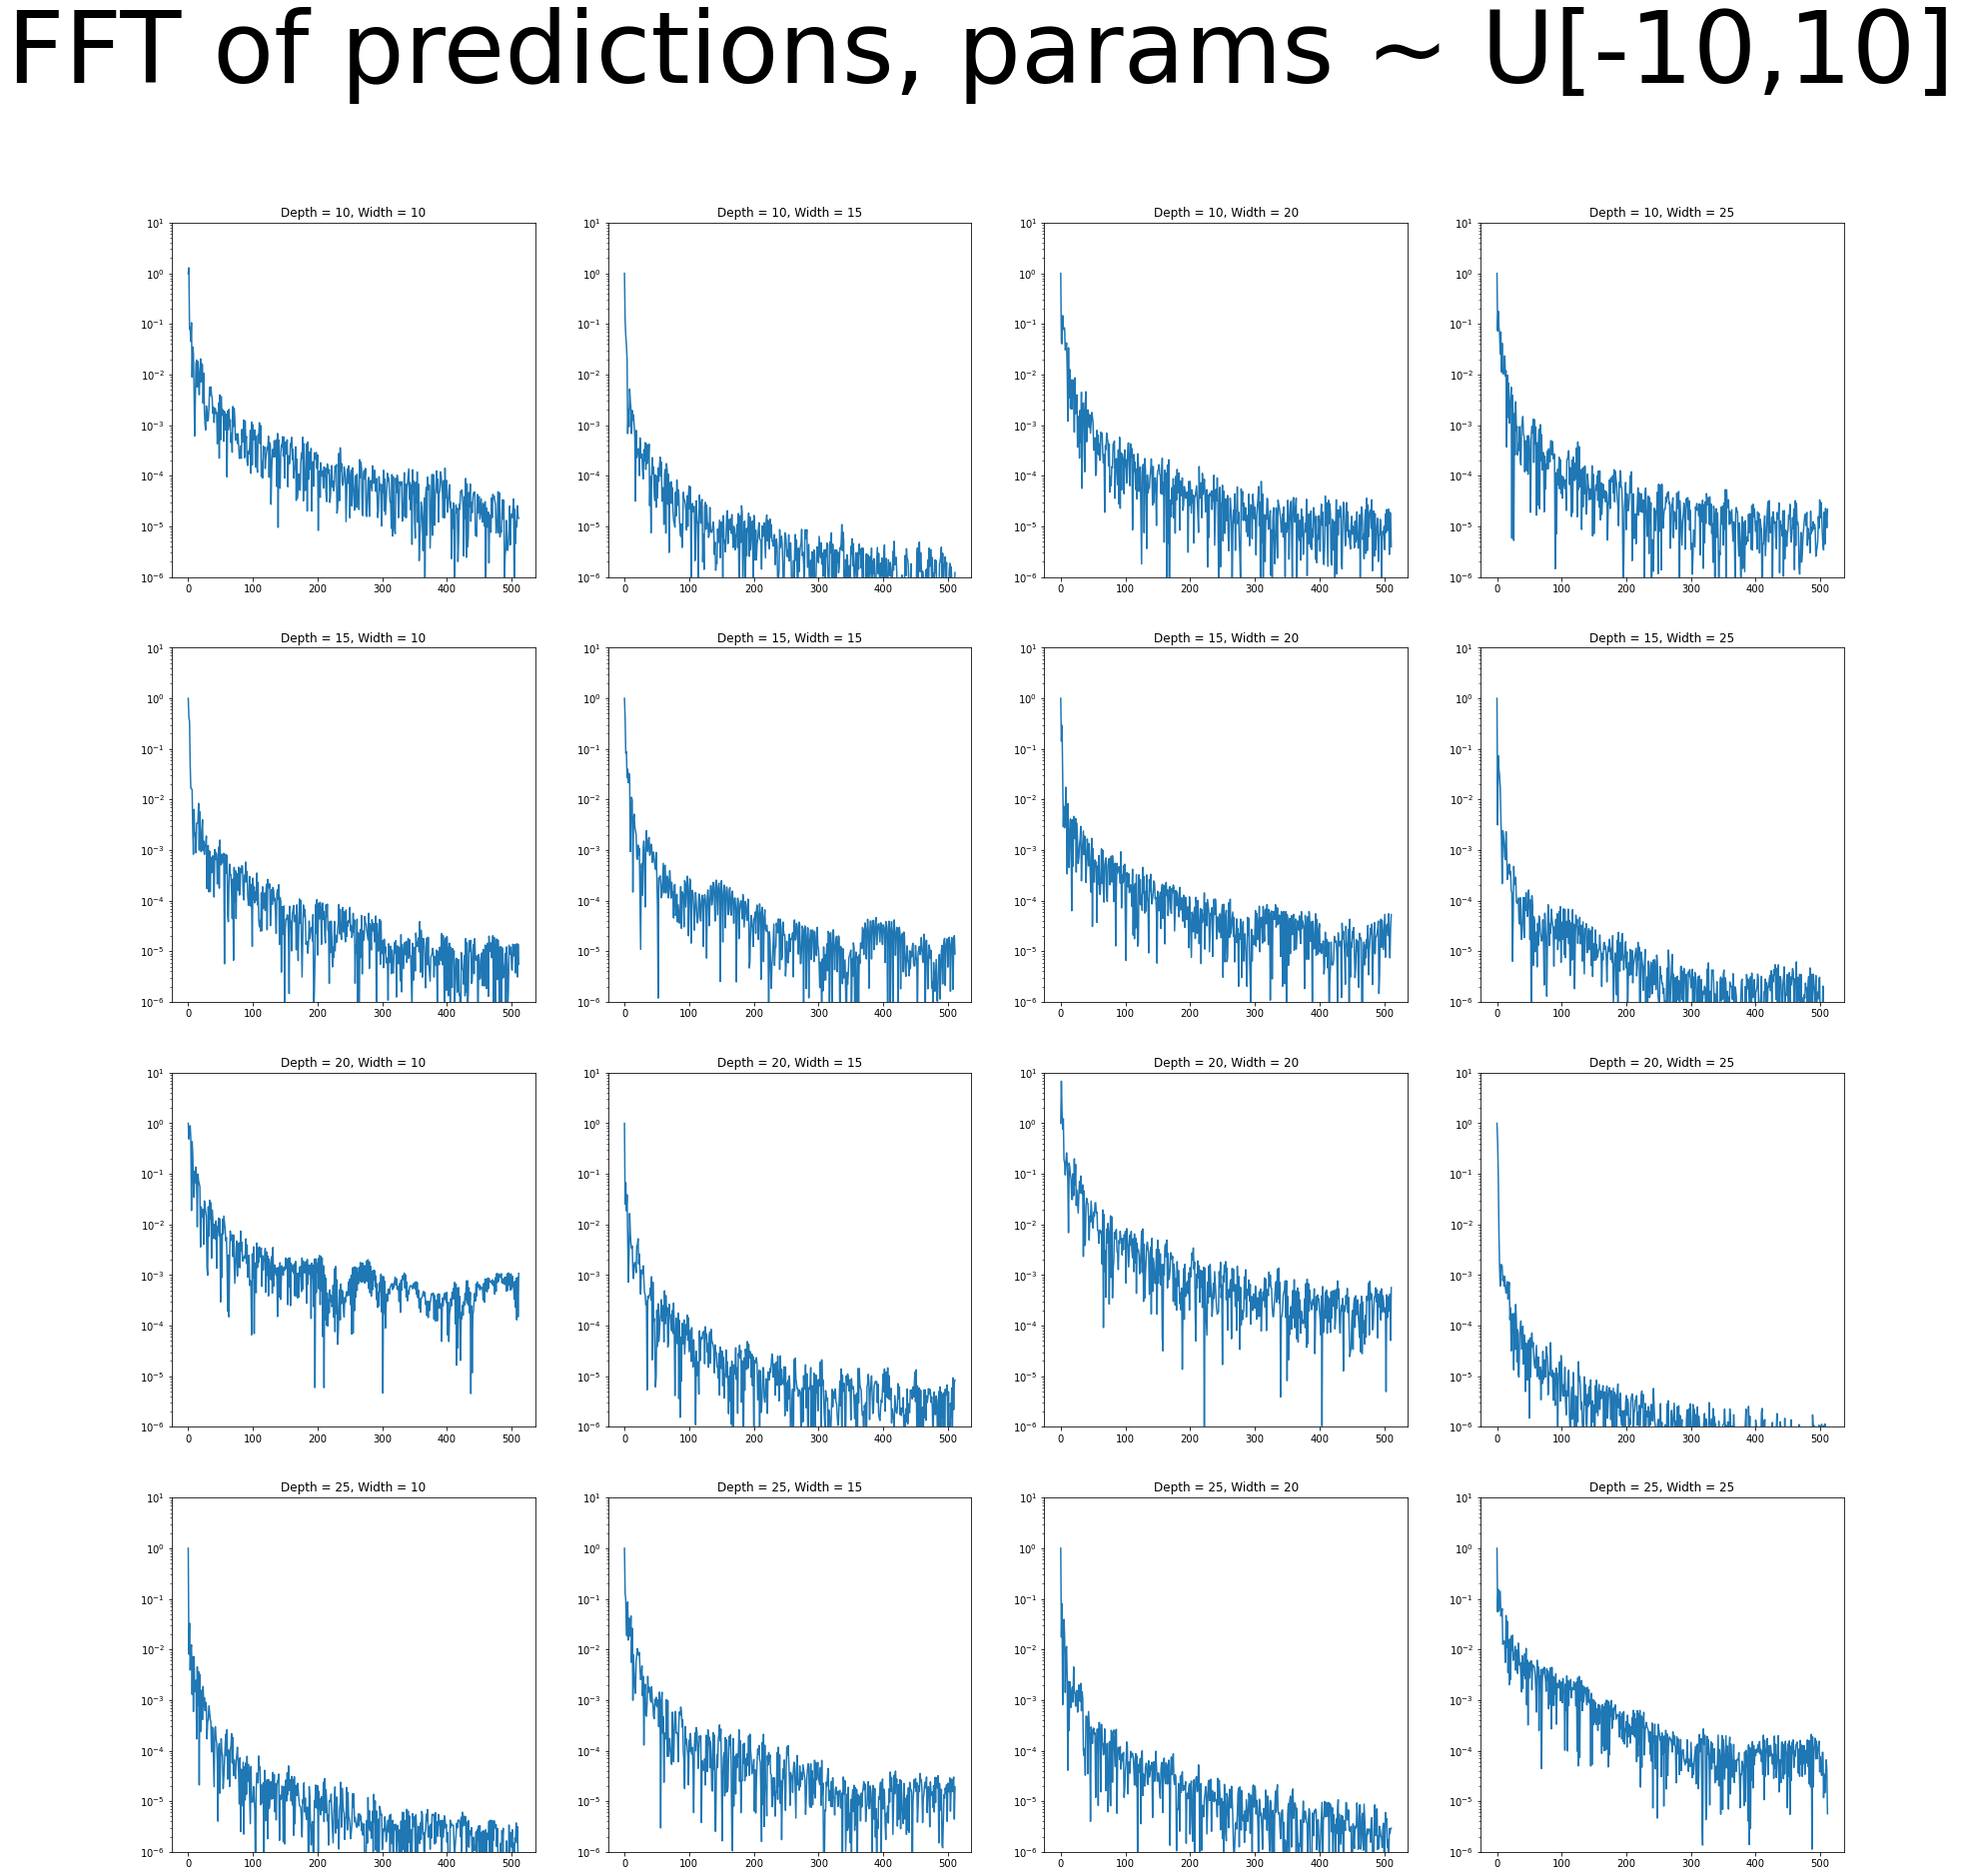

In [42]:
fig1, axs1 = plt.subplots(4, 4, figsize=(30,30))
fig2, axs2 = plt.subplots(4, 4, figsize=(30,30))

a = 10

fig1.suptitle('Predictions with ReLU, params ~ U[-10,10]', fontsize=100)
fig2.suptitle('FFT of predictions, params ~ U[-10,10]', fontsize=100)


for i, width in enumerate(width_list):
    for j, depth in enumerate(depth_list):

        model = DNN2(input_dim=1, output_dim=1, width=width, depth=depth, activation=torch.nn.ReLU(), param_range=a)
        model.init_weights()

        with torch.no_grad():
            y_pred = model(x).flatten()
                    
        total_params = compute_num_params(1, 1, width, depth)
        axs1[j, i].plot(theta, x, "b", linewidth=6, label='Actual')
        axs1[j, i].plot(theta, y_pred, "-.", linewidth=3, color="red", label='Predicted')
        axs1[j, i].set_title('Depth = {}, Width = {}, # parameters = {}'.format(depth, width, total_params))
        
        N = len(y_pred)
        yf = np.fft.fft(np.array(y_pred))
        axs2[j, i].plot(np.abs(yf[:N//2])/np.abs(yf[0]))
        axs2[j, i].set_yscale('log')
        axs2[j, i].set_ylim((10**-6,10**1))
        axs2[j, i].set_title('Depth = {}, Width = {}'.format(depth, width))
        
plt.show()

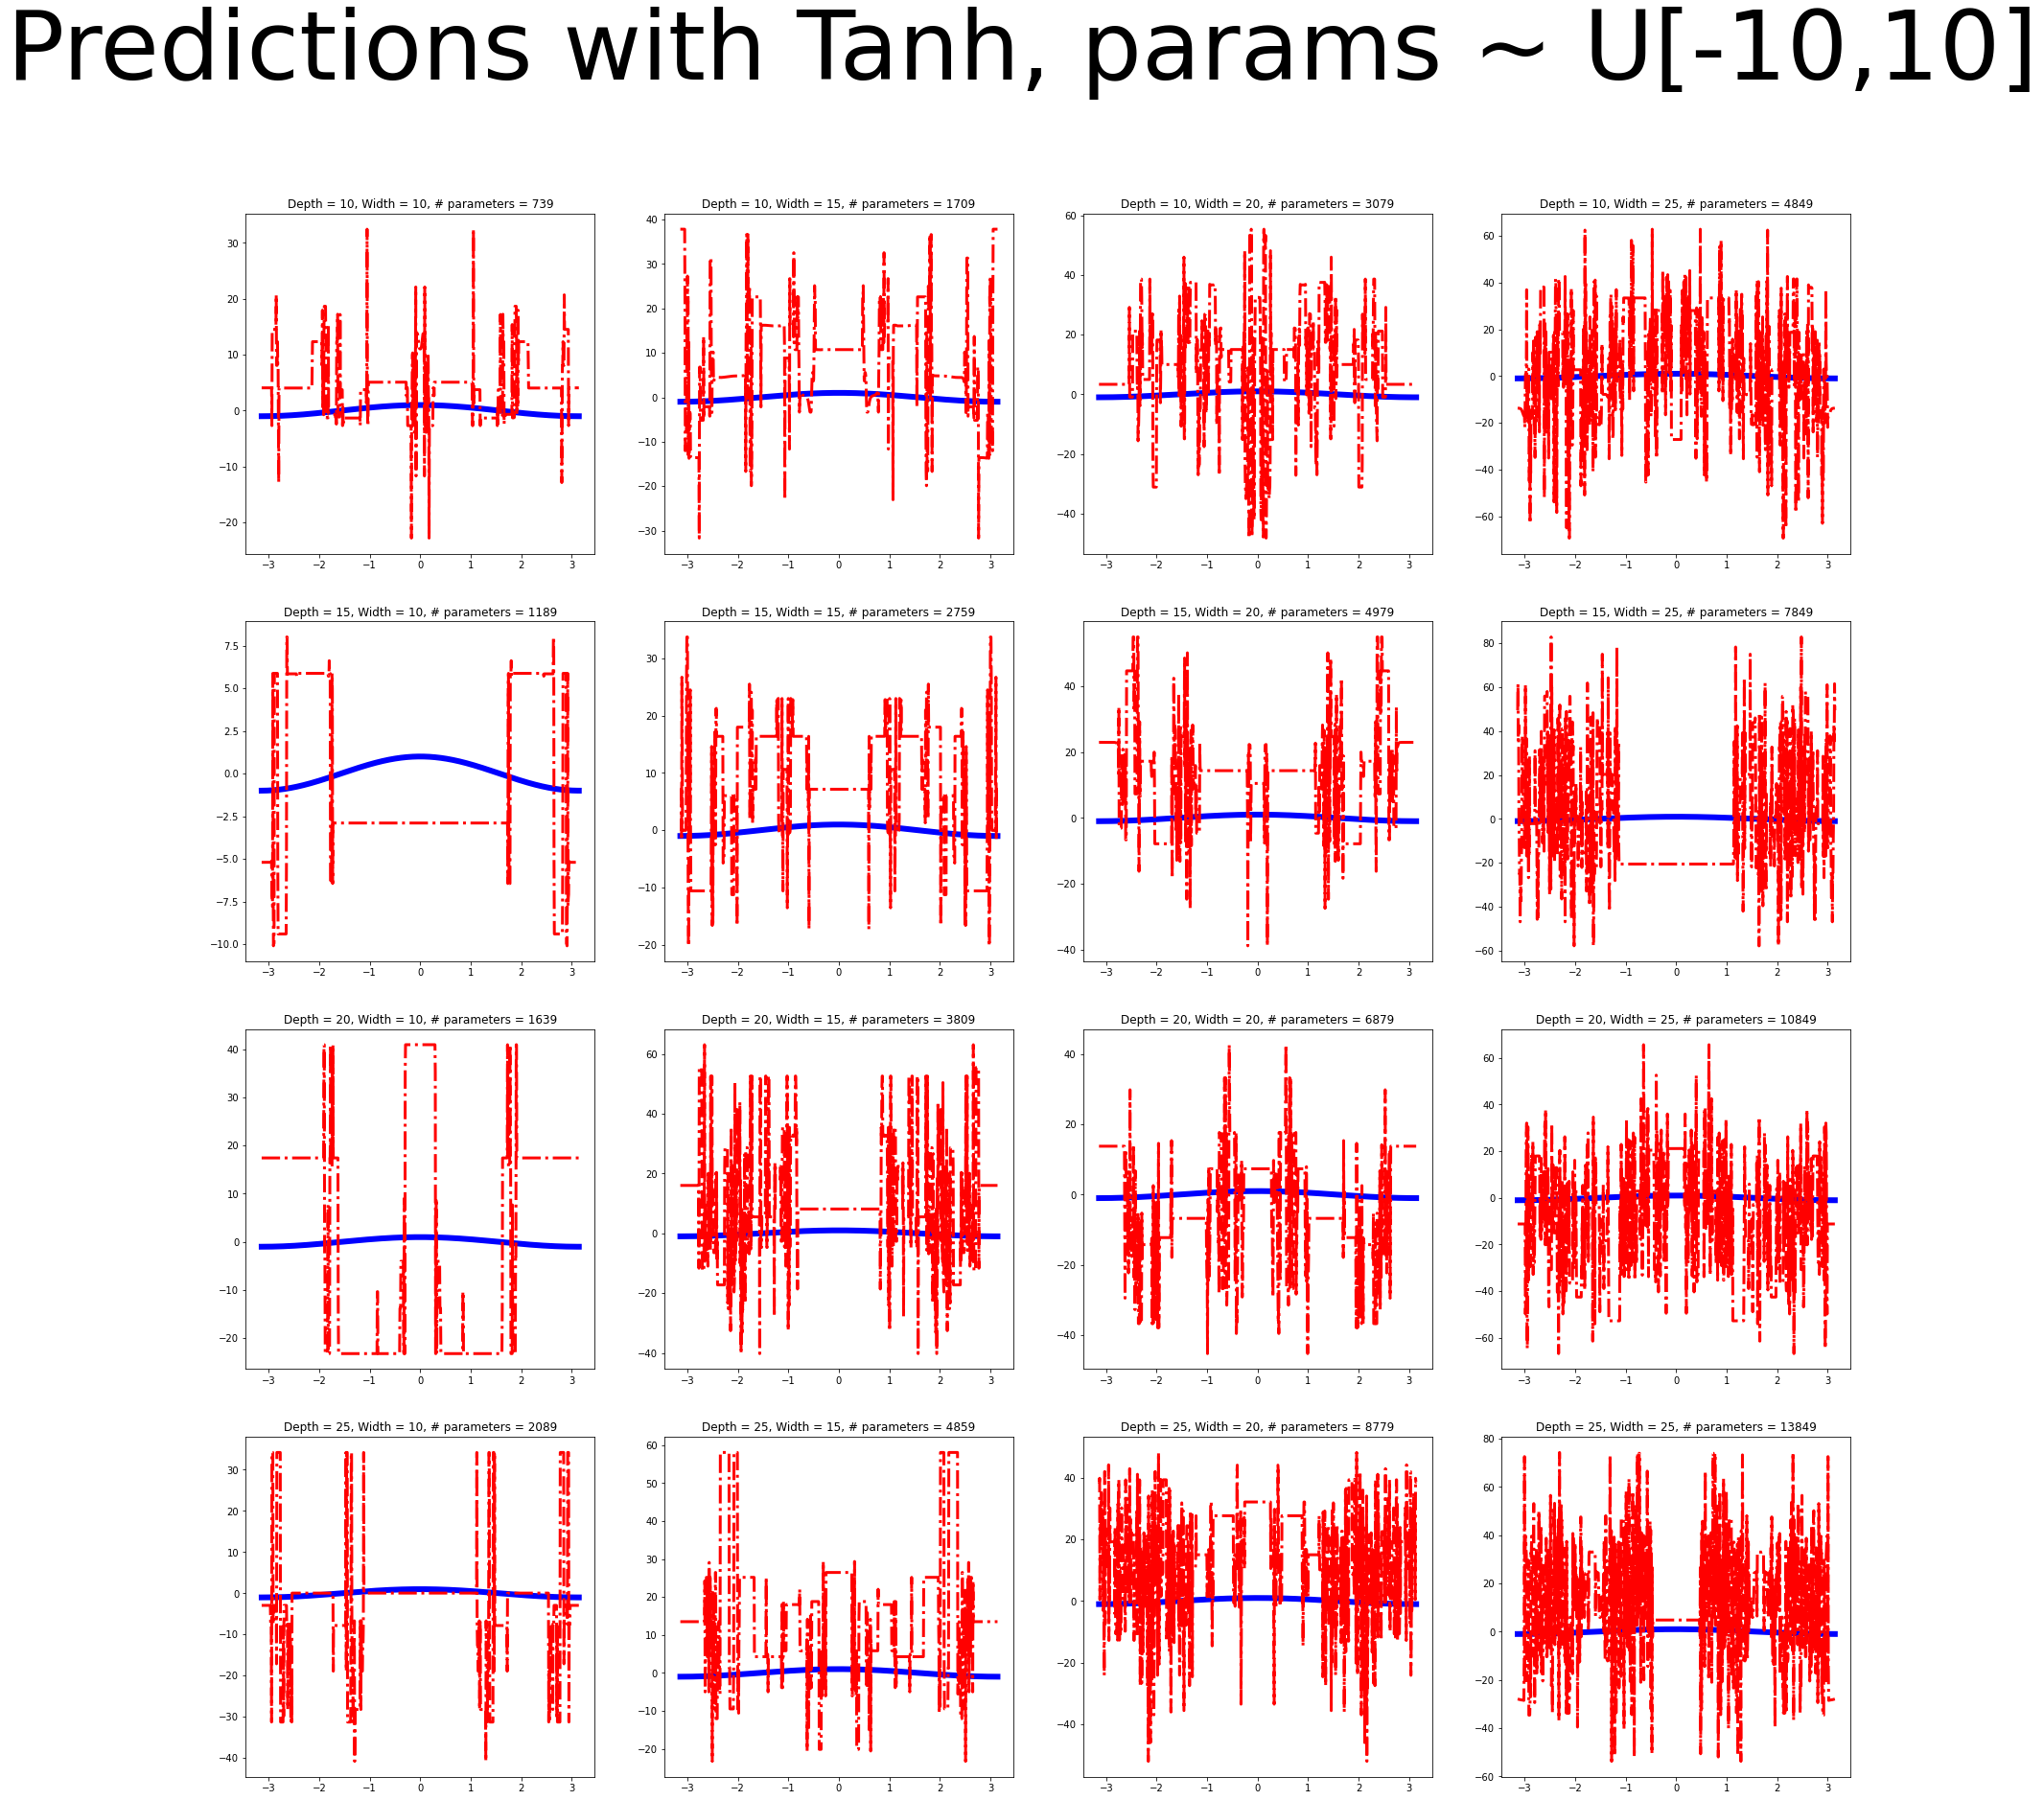

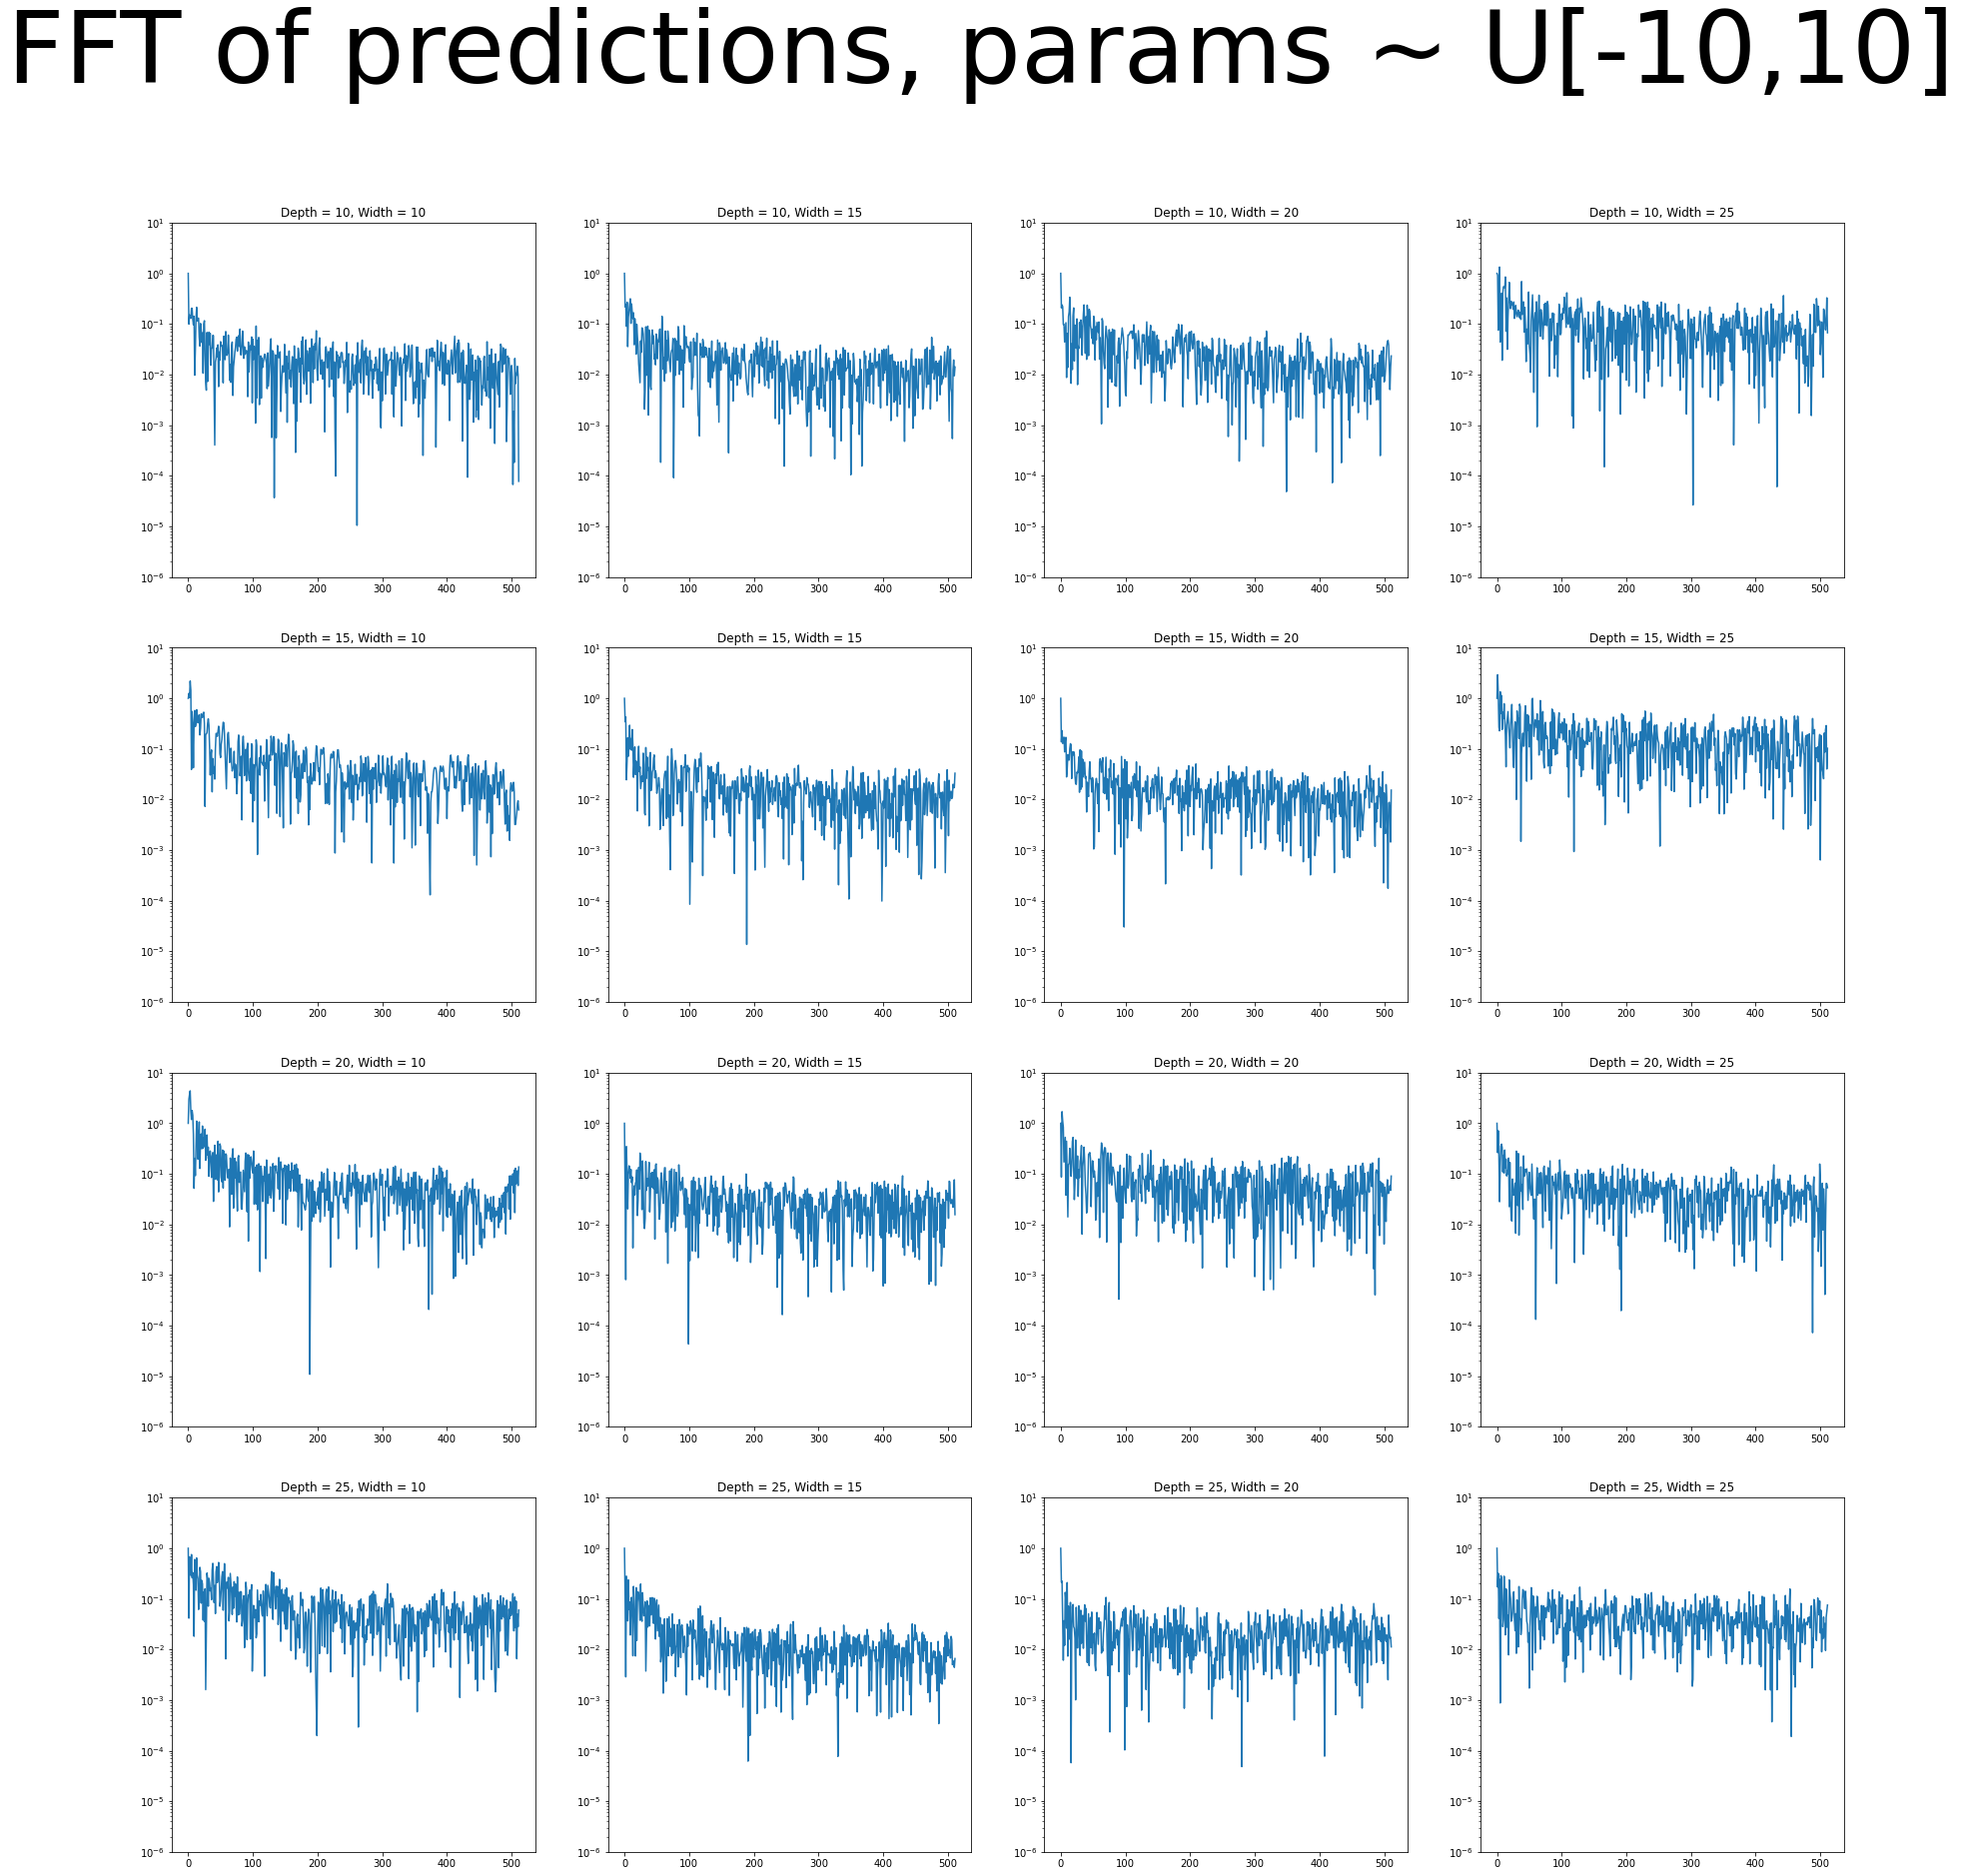

In [43]:
fig1, axs1 = plt.subplots(4, 4, figsize=(30,30))
fig2, axs2 = plt.subplots(4, 4, figsize=(30,30))

a = 10

fig1.suptitle('Predictions with Tanh, params ~ U[-10,10]', fontsize=100)
fig2.suptitle('FFT of predictions, params ~ U[-10,10]', fontsize=100)

for i, width in enumerate(width_list):
    for j, depth in enumerate(depth_list):

        model = DNN2(input_dim=1, output_dim=1, width=width, depth=depth, activation=torch.nn.Tanh(), param_range=a)
        model.init_weights()

        with torch.no_grad():
            y_pred = model(x).flatten()
                    
        total_params = compute_num_params(1, 1, width, depth)
        axs1[j, i].plot(theta, x, "b", linewidth=6, label='Actual')
        axs1[j, i].plot(theta, y_pred, "-.", linewidth=3, color="red", label='Predicted')
        axs1[j, i].set_title('Depth = {}, Width = {}, # parameters = {}'.format(depth, width, total_params))
        
        N = len(y_pred)
        yf = np.fft.fft(np.array(y_pred))
        axs2[j, i].plot(np.abs(yf[:N//2])/np.abs(yf[0]))
        axs2[j, i].set_yscale('log')
        axs2[j, i].set_ylim((10**-6,10**1))
        axs2[j, i].set_title('Depth = {}, Width = {}'.format(depth, width))
        
plt.show()

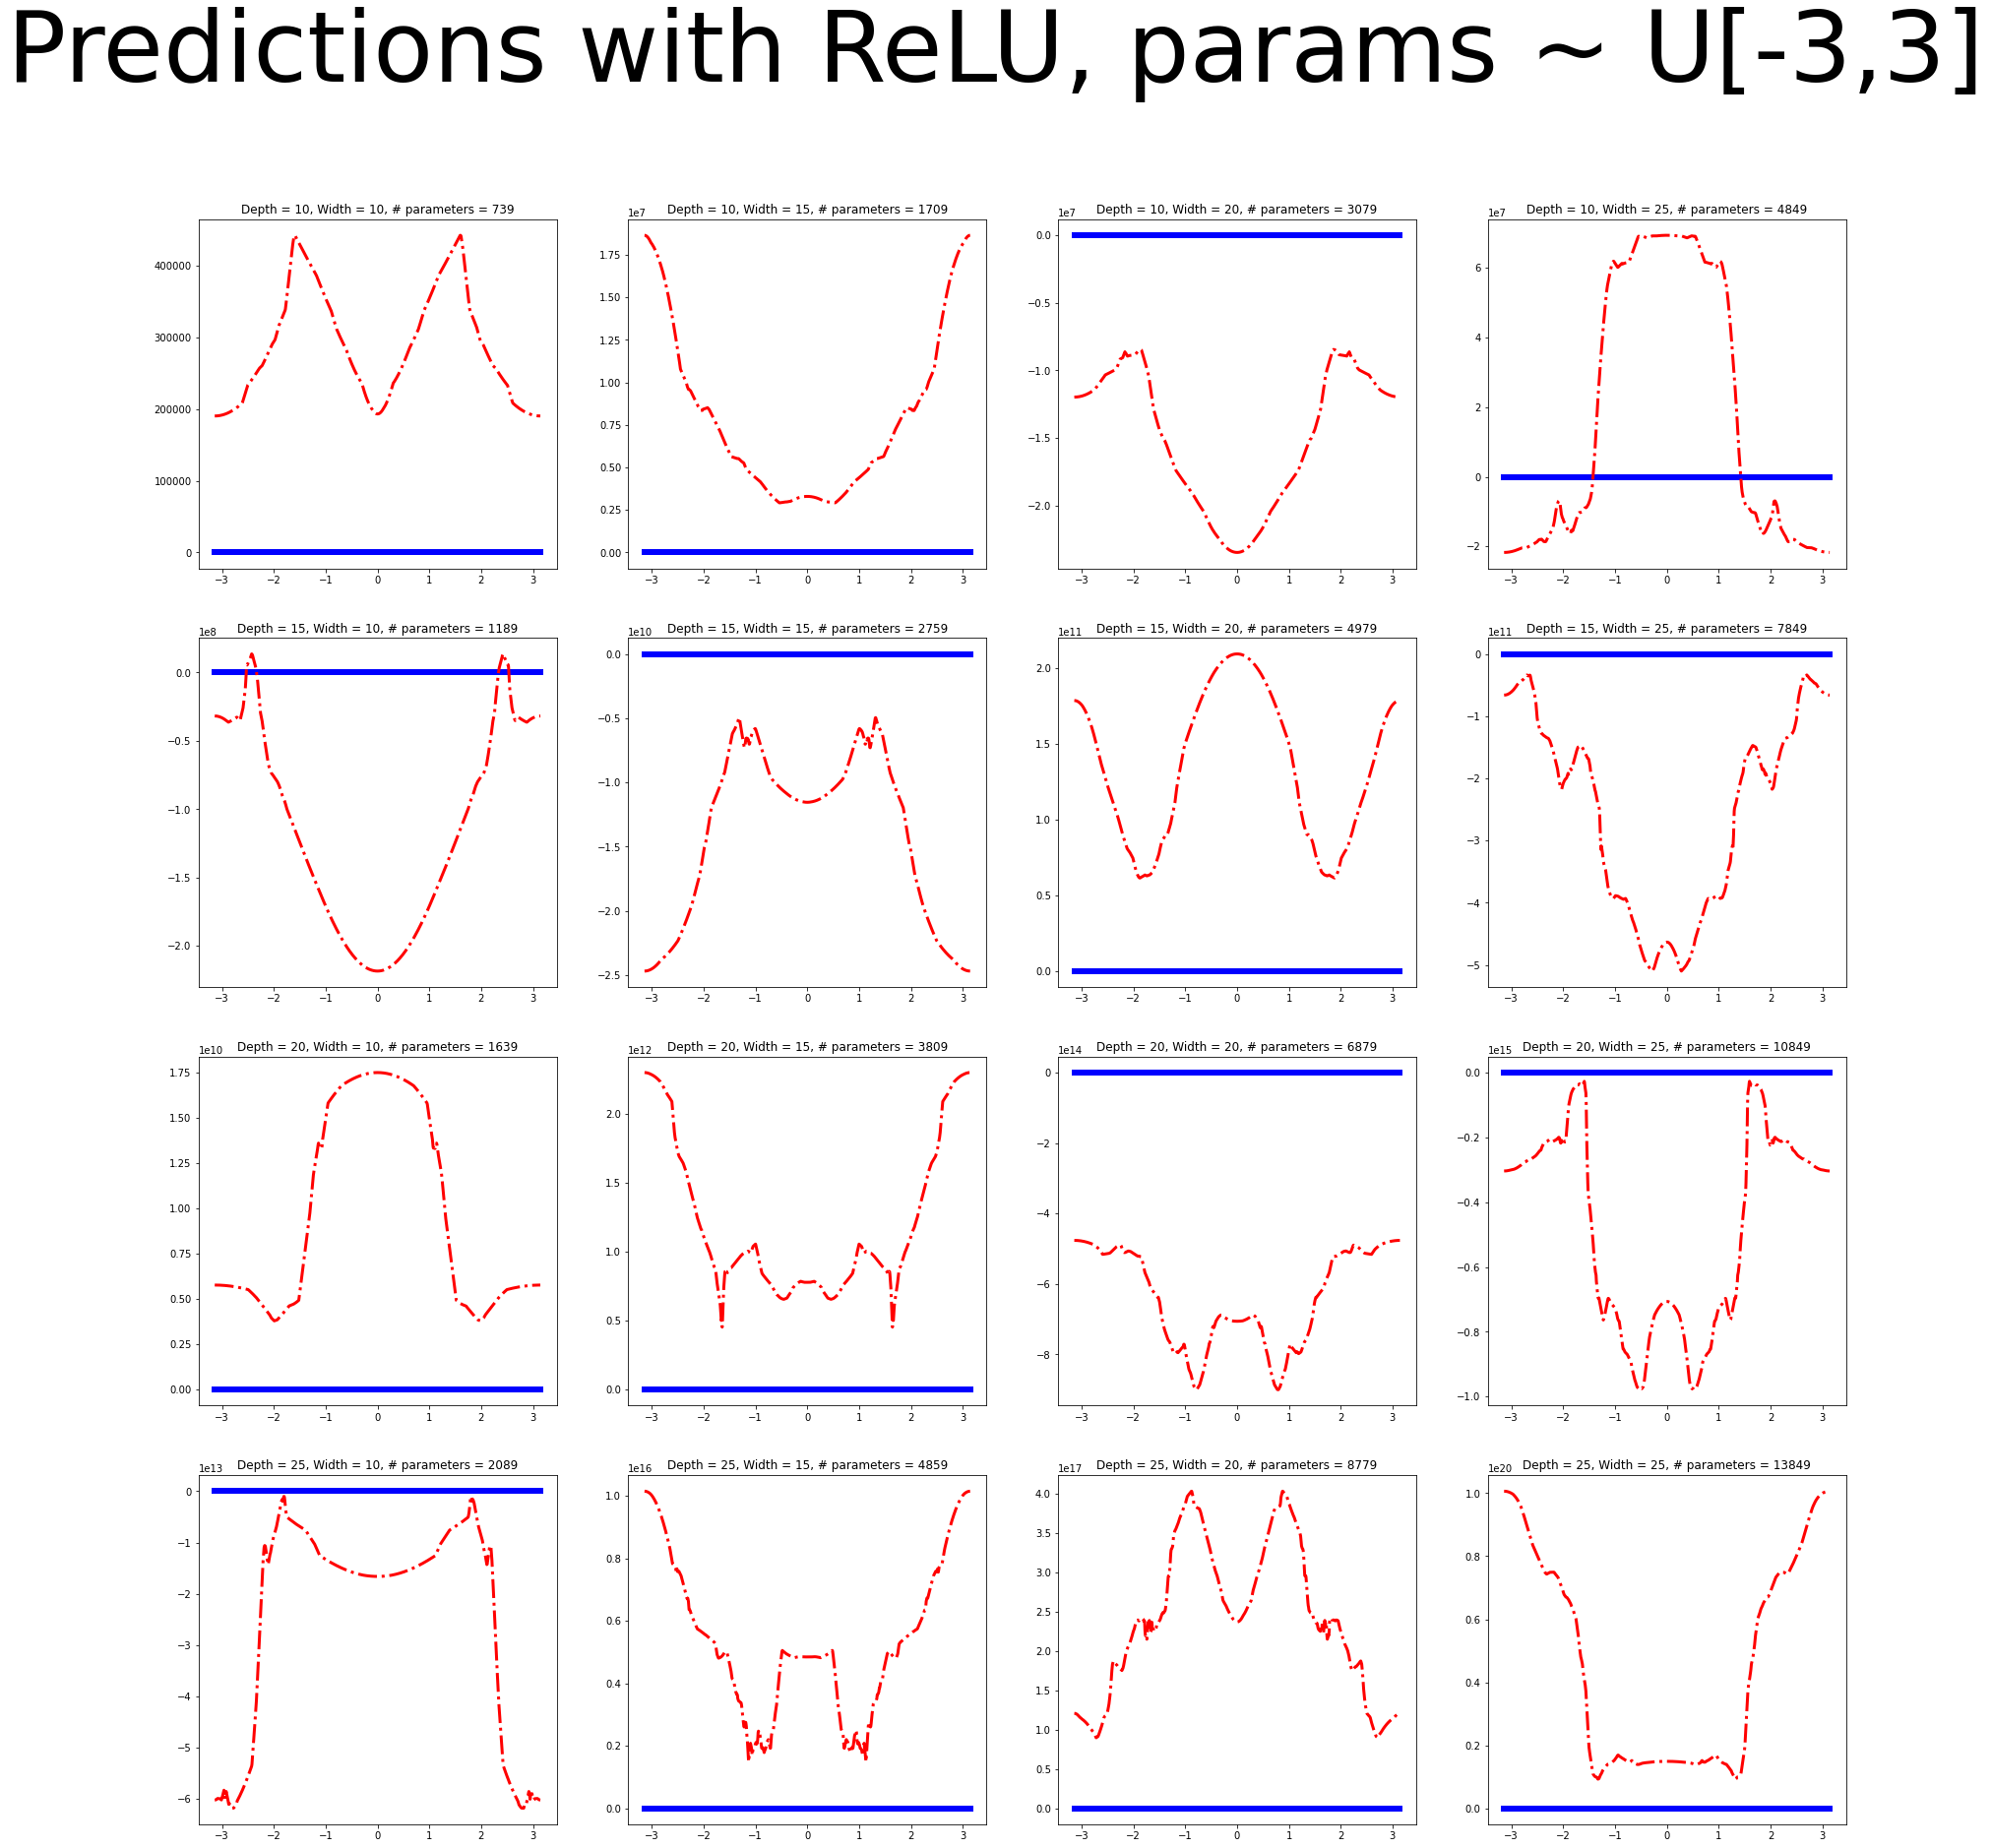

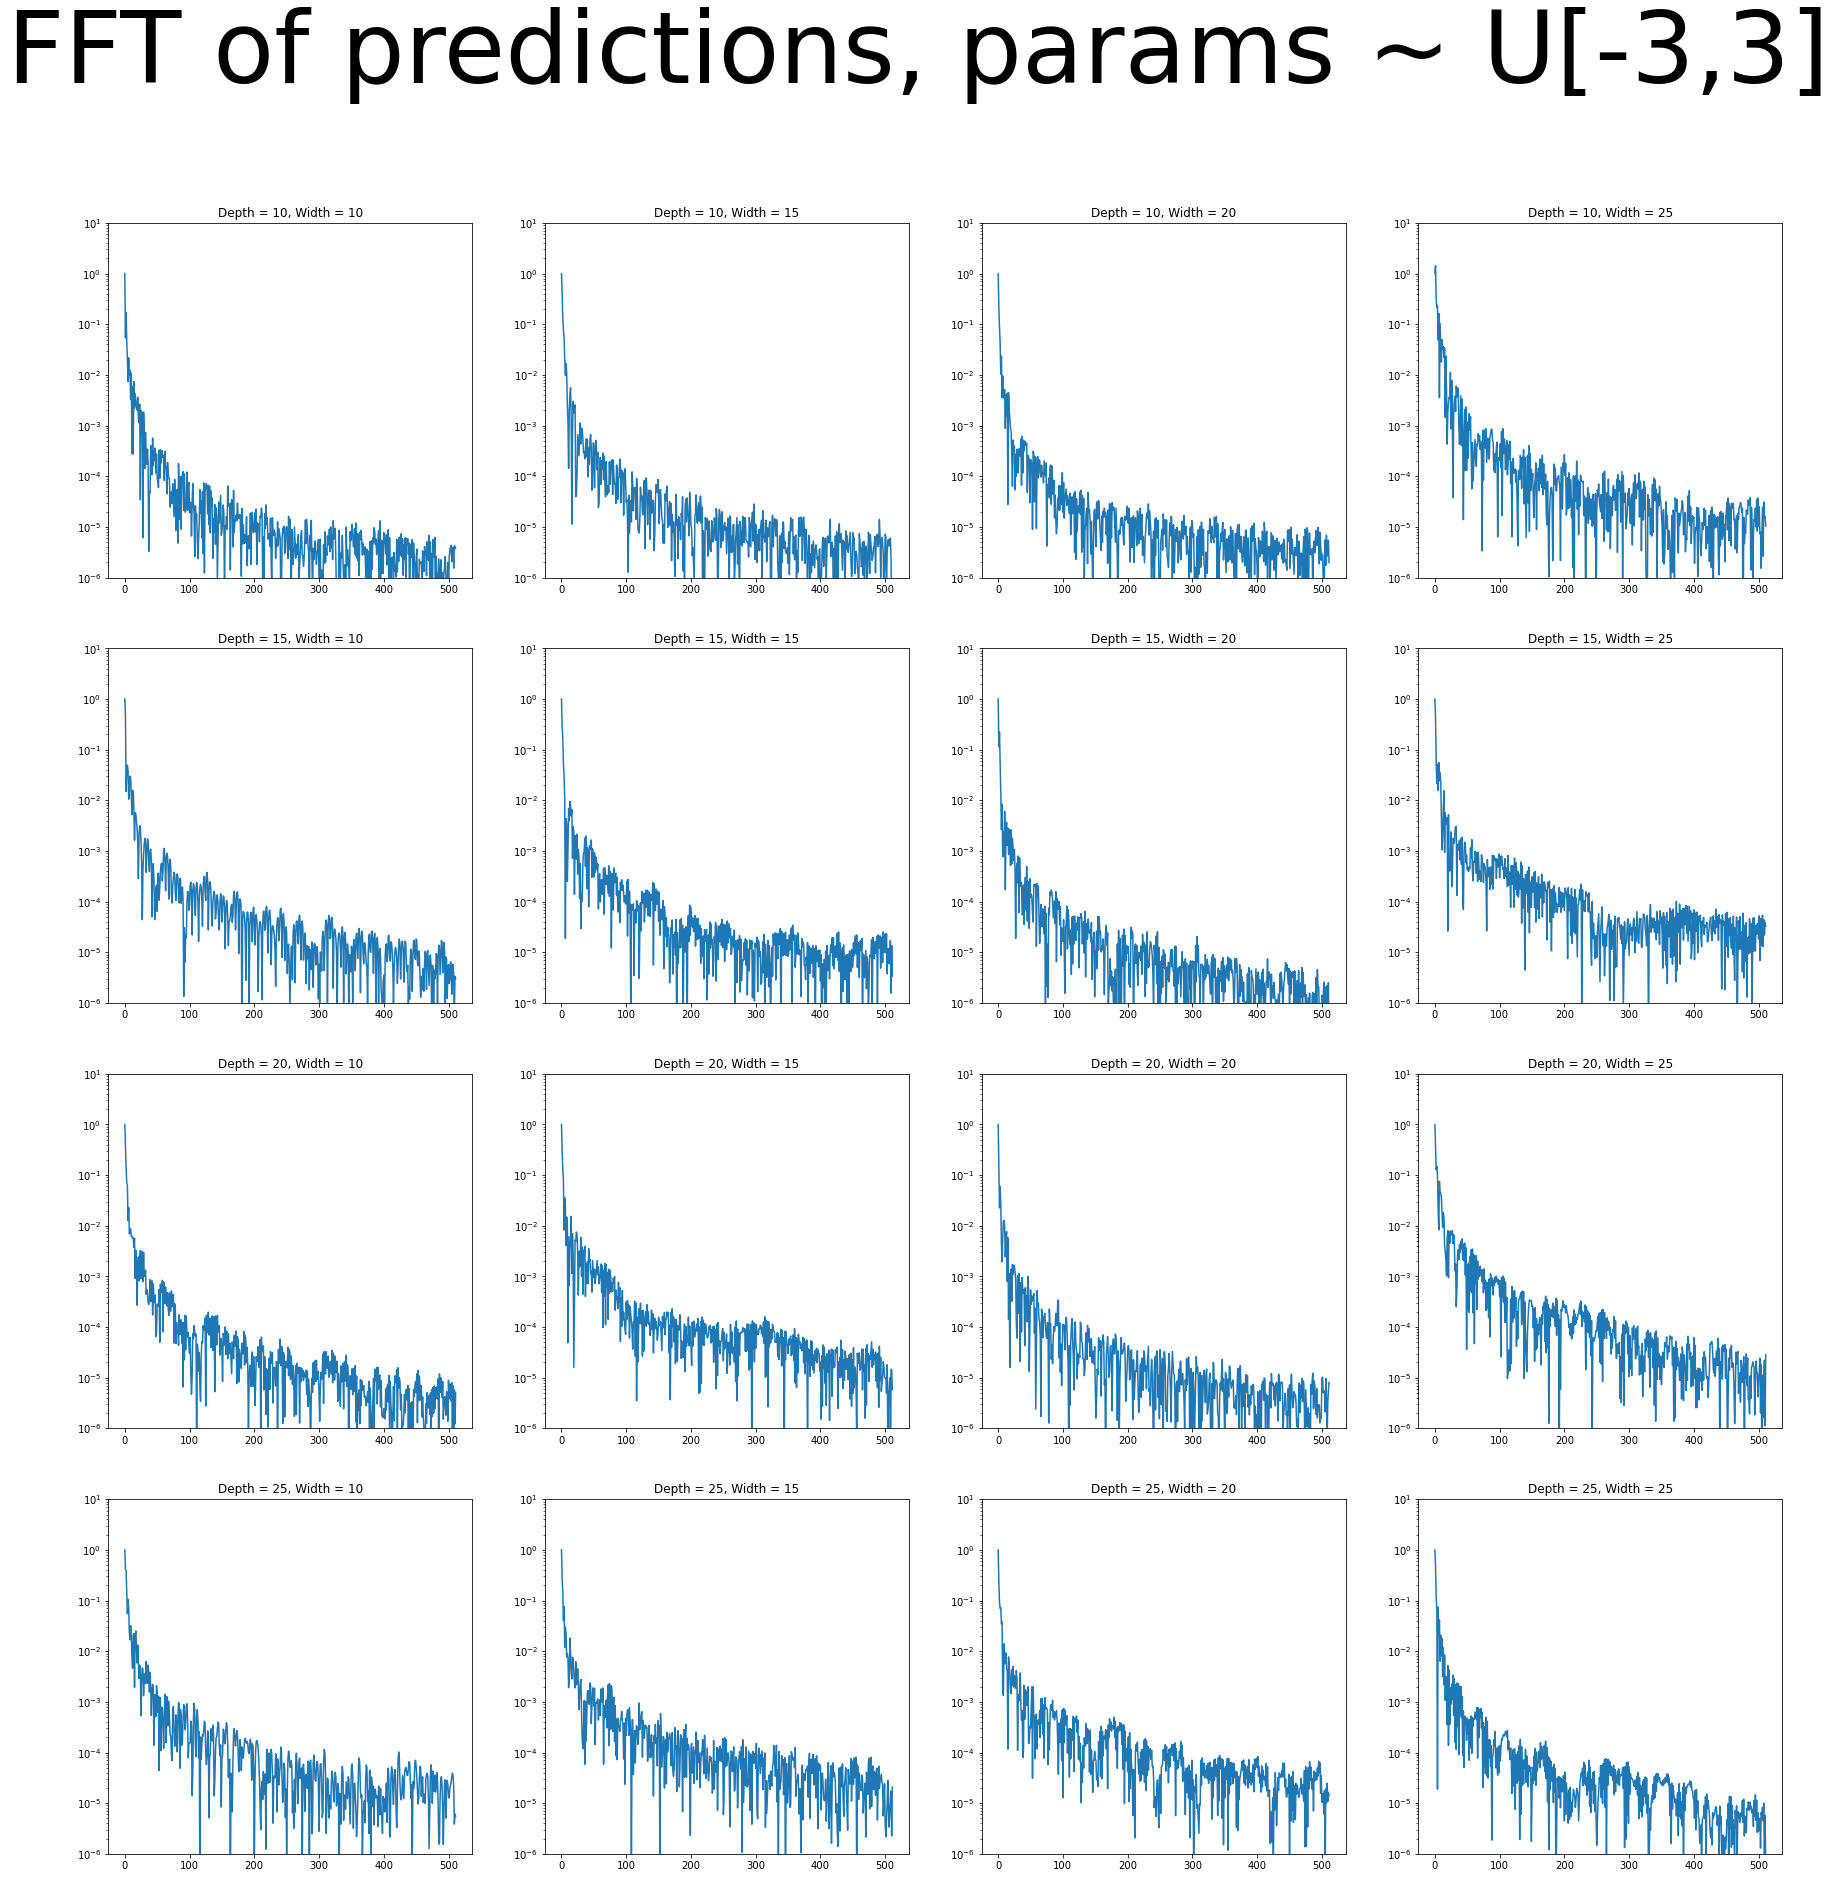

In [44]:
fig1, axs1 = plt.subplots(4, 4, figsize=(30,30))
fig2, axs2 = plt.subplots(4, 4, figsize=(30,30))

fig1.suptitle('Predictions with ReLU, params ~ U[-3,3]', fontsize=100)
fig2.suptitle('FFT of predictions, params ~ U[-3,3]', fontsize=100)

for i, width in enumerate(width_list):
    for j, depth in enumerate(depth_list):

        model = DNN2(input_dim=1, output_dim=1, width=width, depth=depth, activation=torch.nn.ReLU(), param_range=3)
        model.init_weights()

        with torch.no_grad():
            y_pred = model(x).flatten()
                    
        total_params = compute_num_params(1, 1, width, depth)
        axs1[j, i].plot(theta, x, "b", linewidth=6, label='Actual')
        axs1[j, i].plot(theta, y_pred, "-.", linewidth=3, color="red", label='Predicted')
        axs1[j, i].set_title('Depth = {}, Width = {}, # parameters = {}'.format(depth, width, total_params))
        
        N = len(y_pred)
        yf = np.fft.fft(np.array(y_pred))
        axs2[j, i].plot(np.abs(yf[:N//2])/np.abs(yf[0]))
        axs2[j, i].set_yscale('log')
        axs2[j, i].set_ylim((10**-6,10**1))
        axs2[j, i].set_title('Depth = {}, Width = {}'.format(depth, width))
        
plt.show()

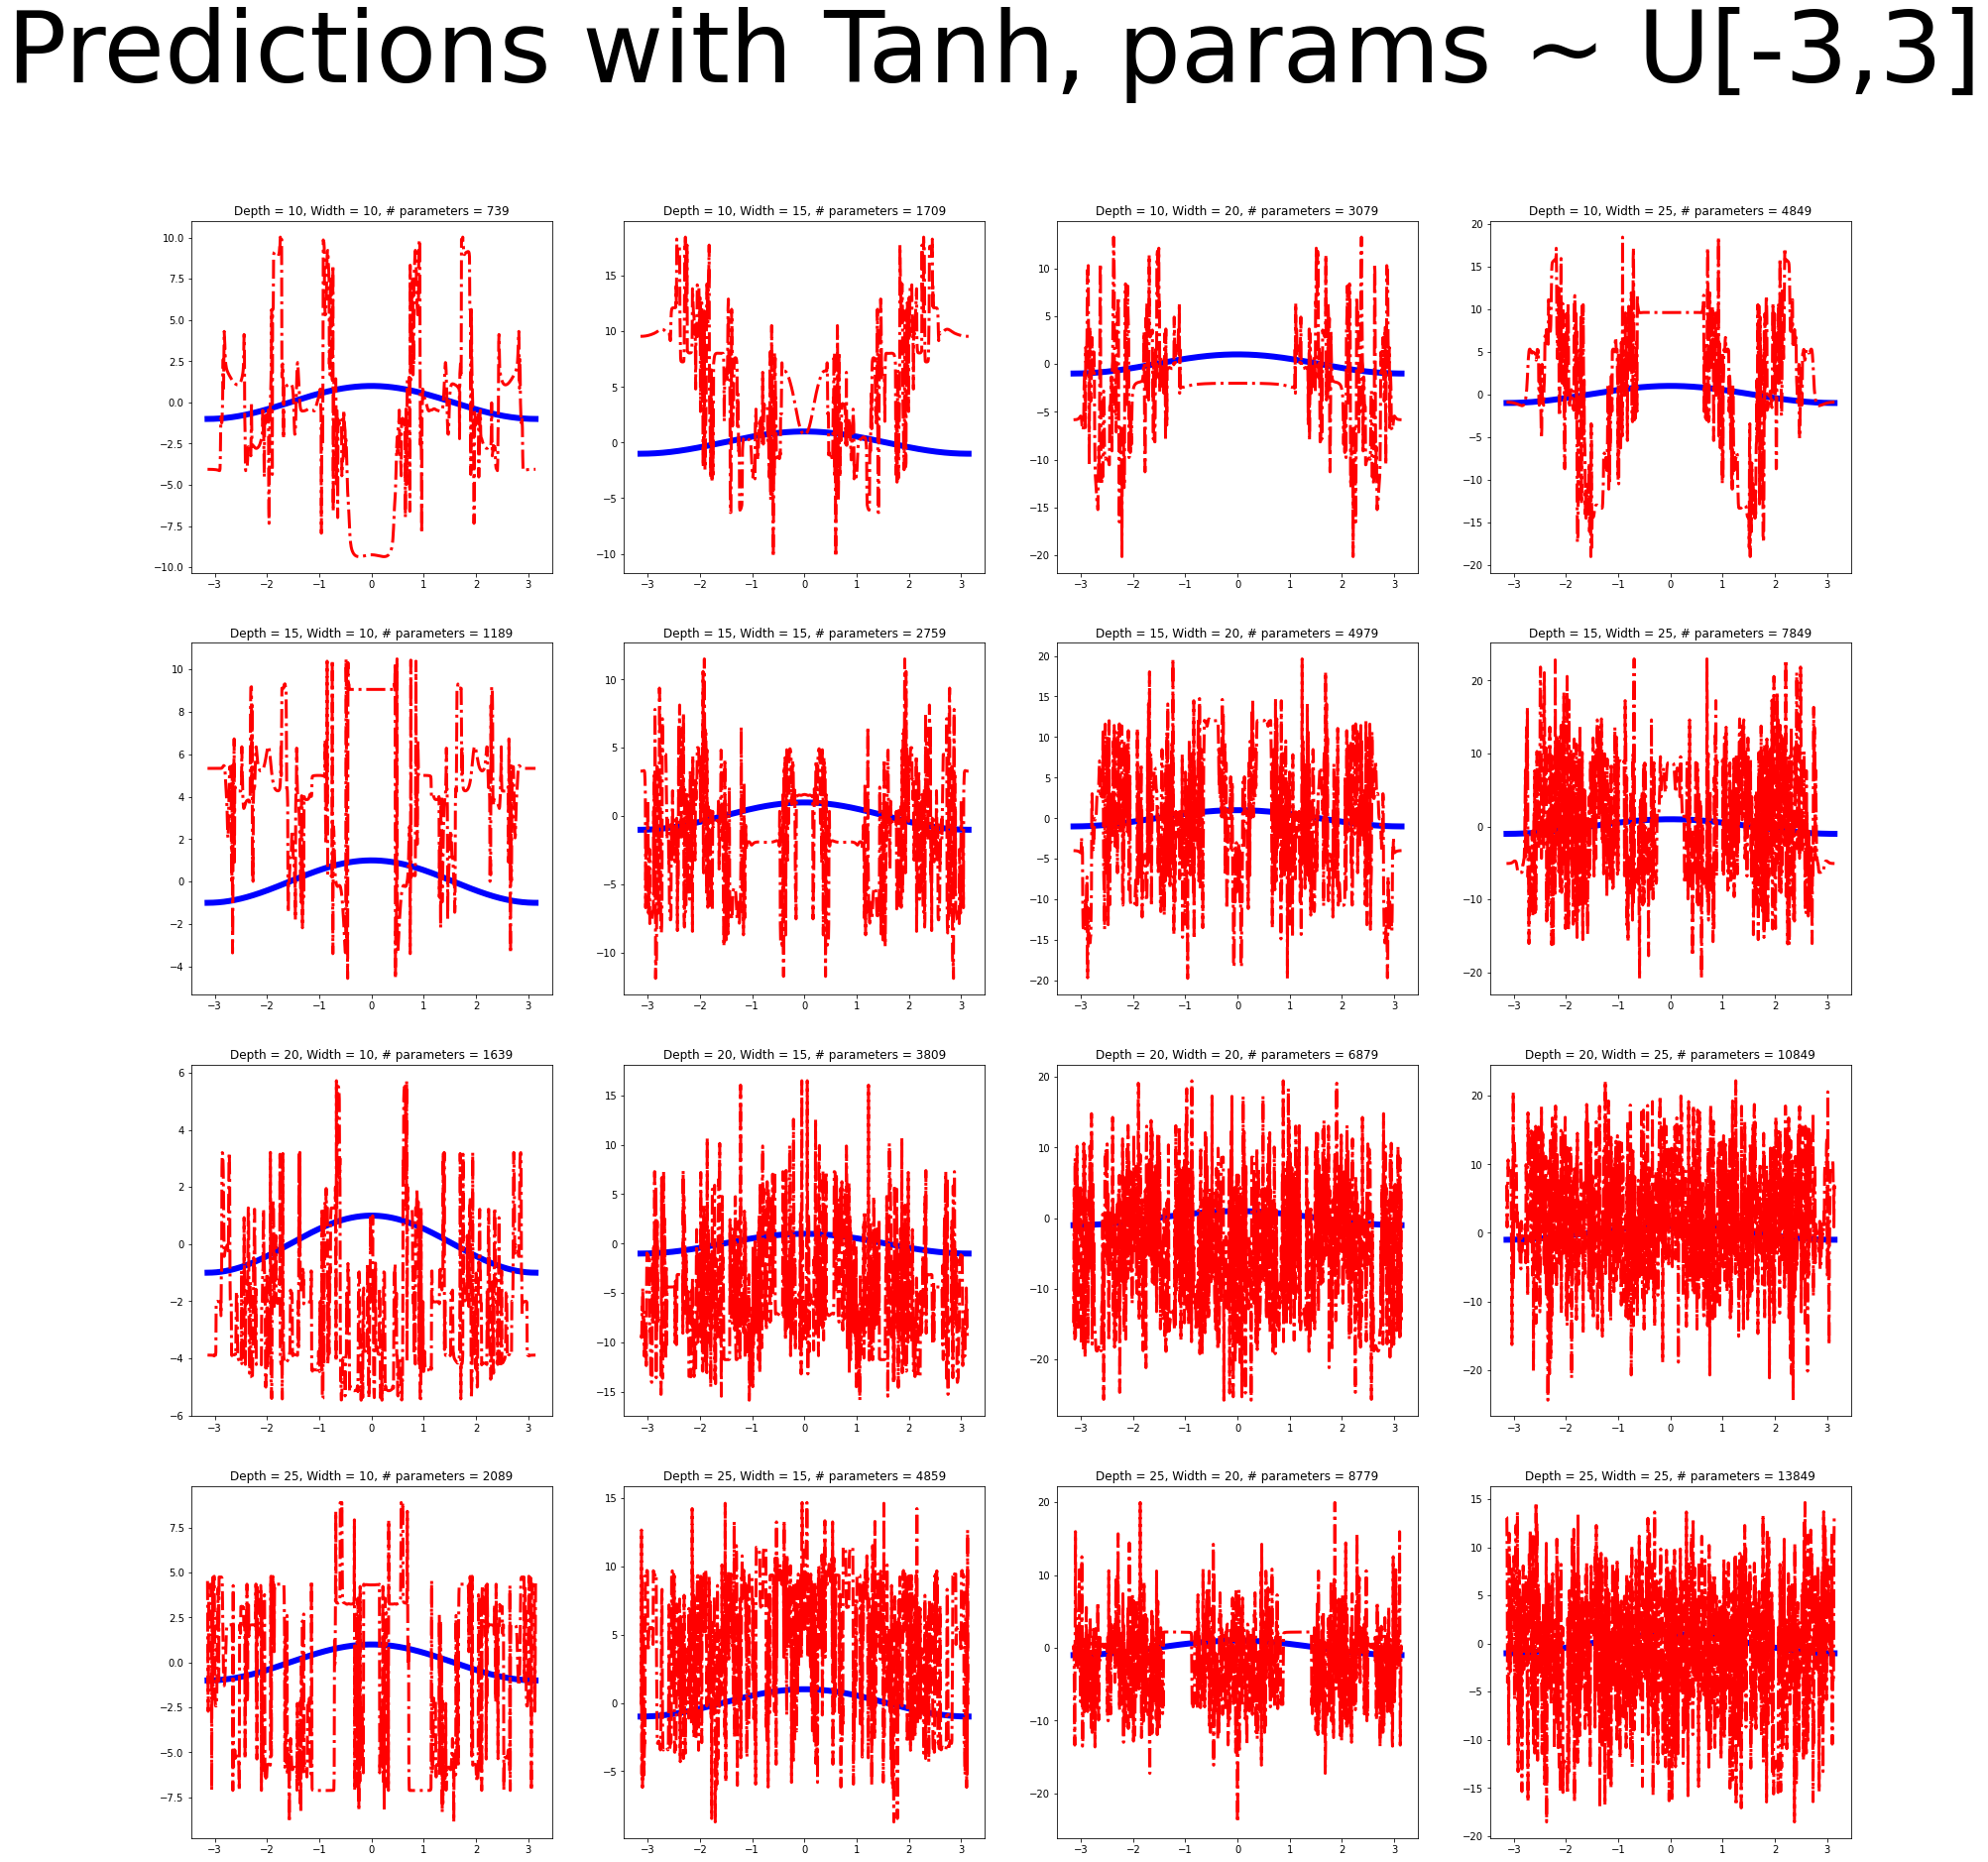

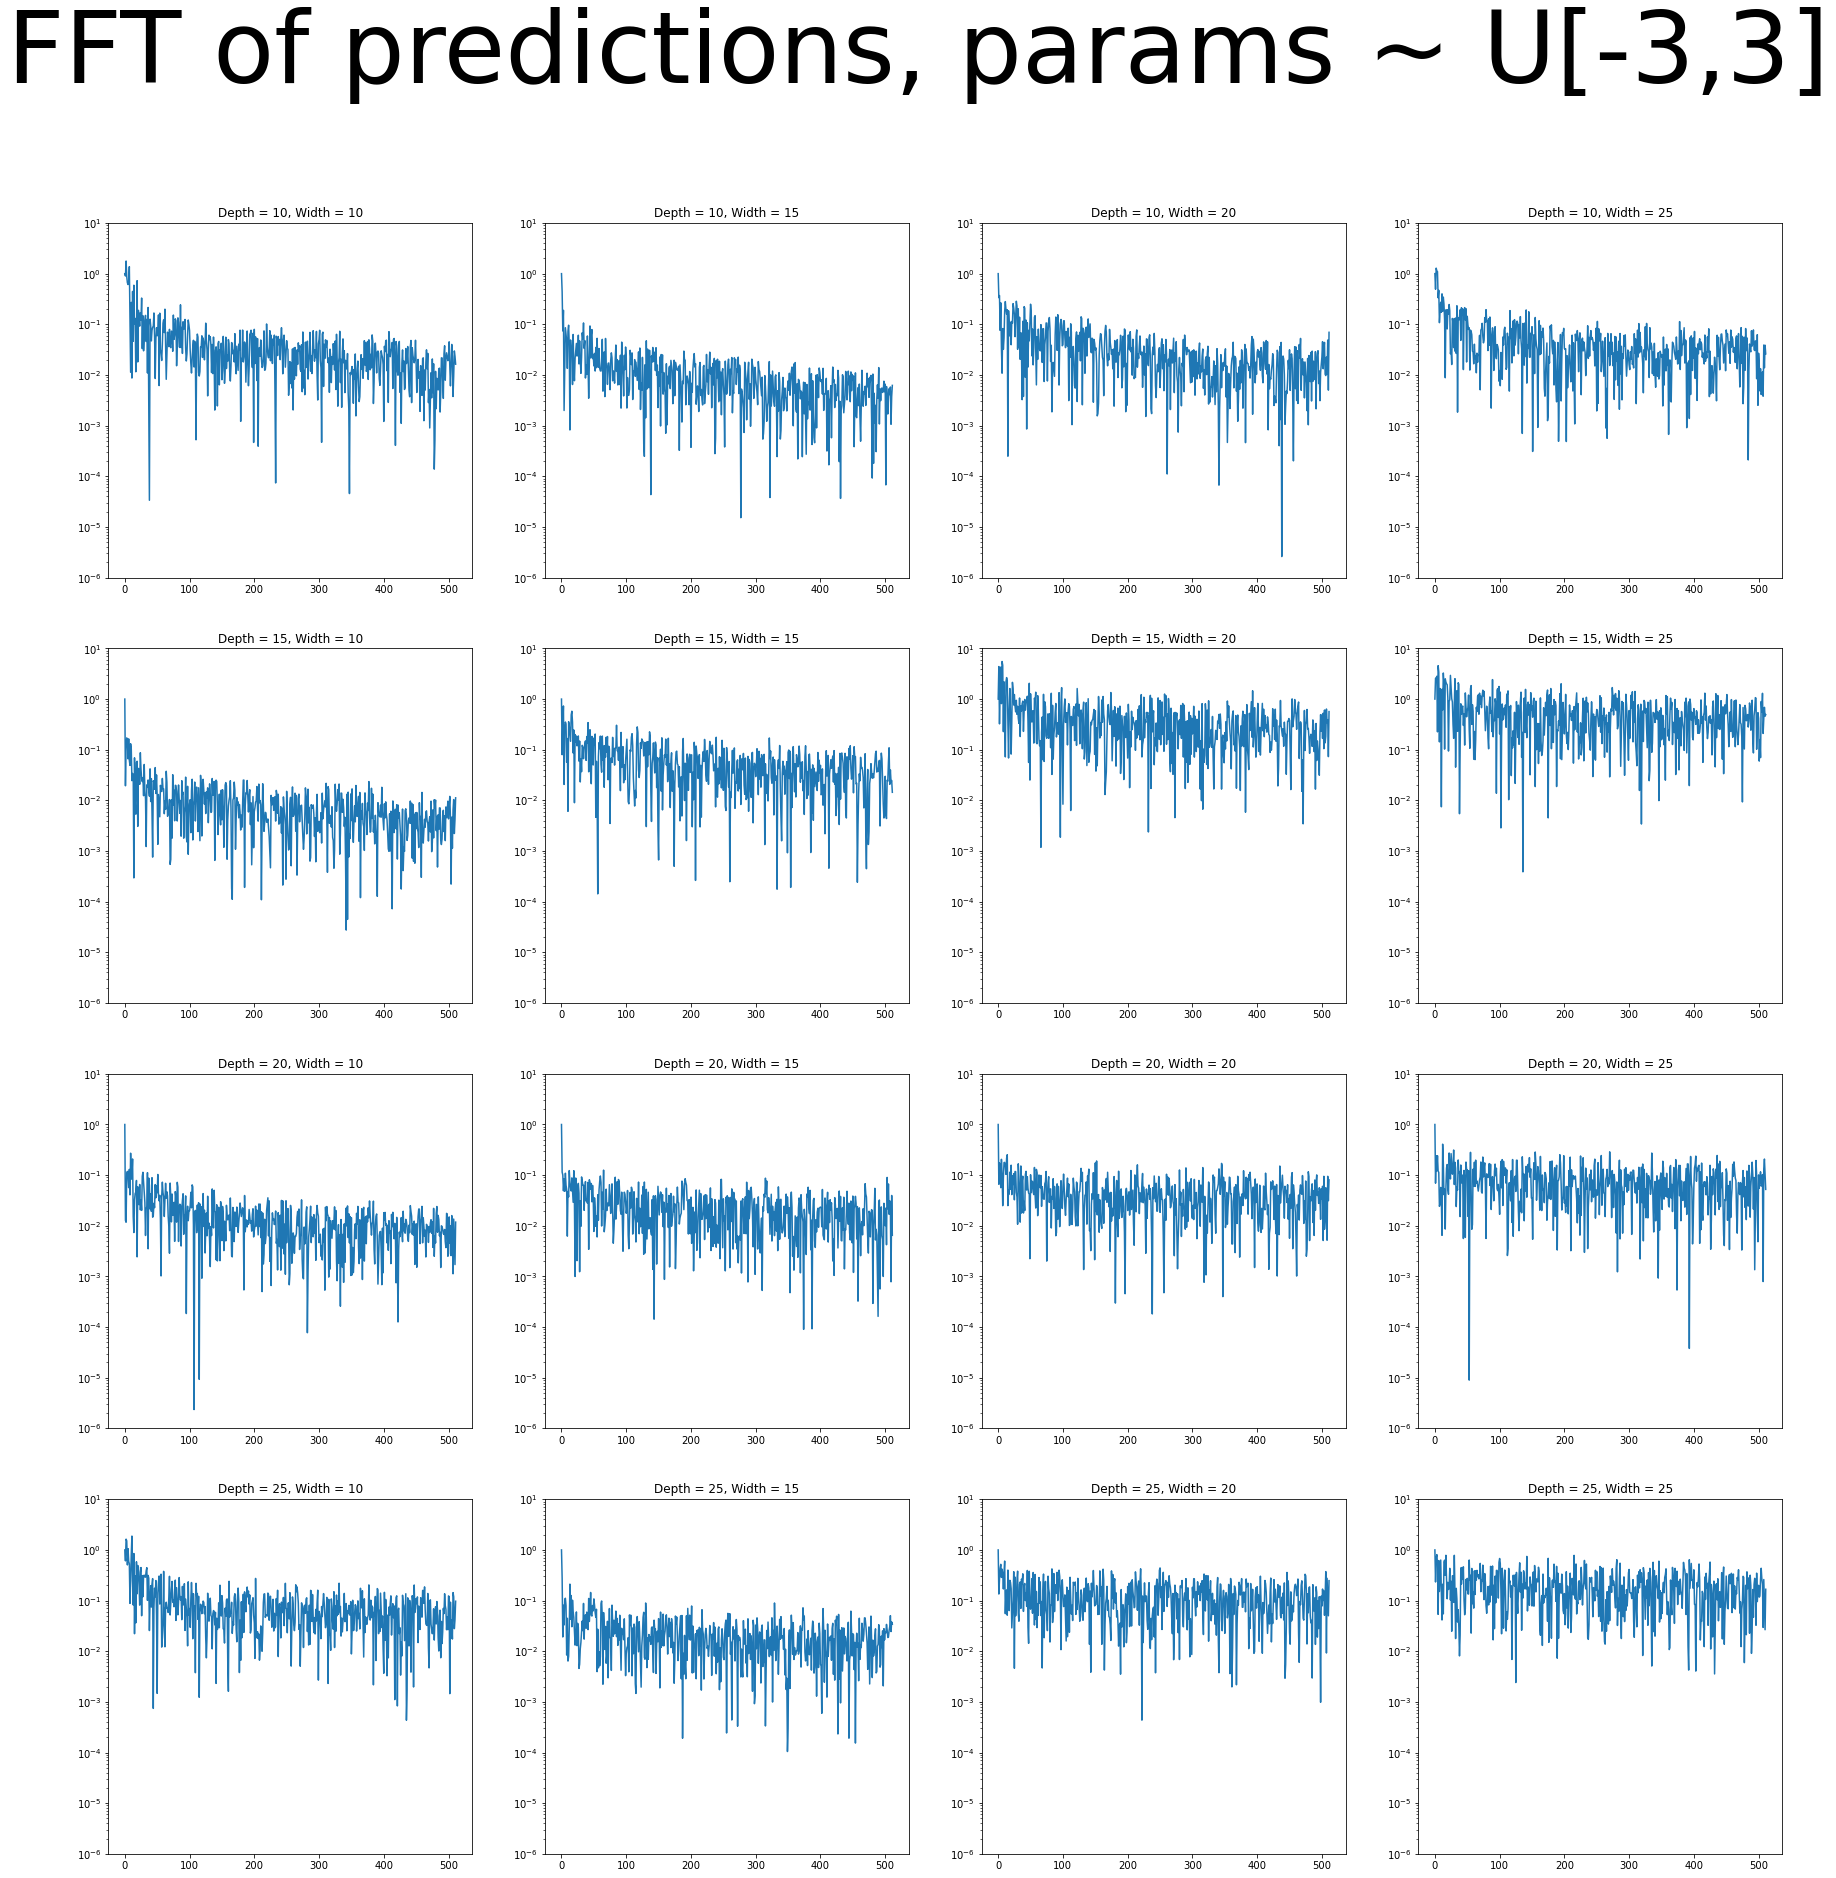

In [45]:
fig1, axs1 = plt.subplots(4, 4, figsize=(30,30))
fig2, axs2 = plt.subplots(4, 4, figsize=(30,30))

fig1.suptitle('Predictions with Tanh, params ~ U[-3,3]', fontsize=100)
fig2.suptitle('FFT of predictions, params ~ U[-3,3]', fontsize=100)

for i, width in enumerate(width_list):
    for j, depth in enumerate(depth_list):

        model = DNN2(input_dim=1, output_dim=1, width=width, depth=depth, activation=torch.nn.Tanh(), param_range=3)
        model.init_weights()

        with torch.no_grad():
            y_pred = model(x).flatten()
                    
        total_params = compute_num_params(1, 1, width, depth)
        axs1[j, i].plot(theta, x, "b", linewidth=6, label='Actual')
        axs1[j, i].plot(theta, y_pred, "-.", linewidth=3, color="red", label='Predicted')
        axs1[j, i].set_title('Depth = {}, Width = {}, # parameters = {}'.format(depth, width, total_params))
        
        N = len(y_pred)
        yf = np.fft.fft(np.array(y_pred))
        axs2[j, i].plot(np.abs(yf[:N//2])/np.abs(yf[0]))
        axs2[j, i].set_yscale('log')
        axs2[j, i].set_ylim((10**-6,10**1))
        axs2[j, i].set_title('Depth = {}, Width = {}'.format(depth, width))
        
plt.show()

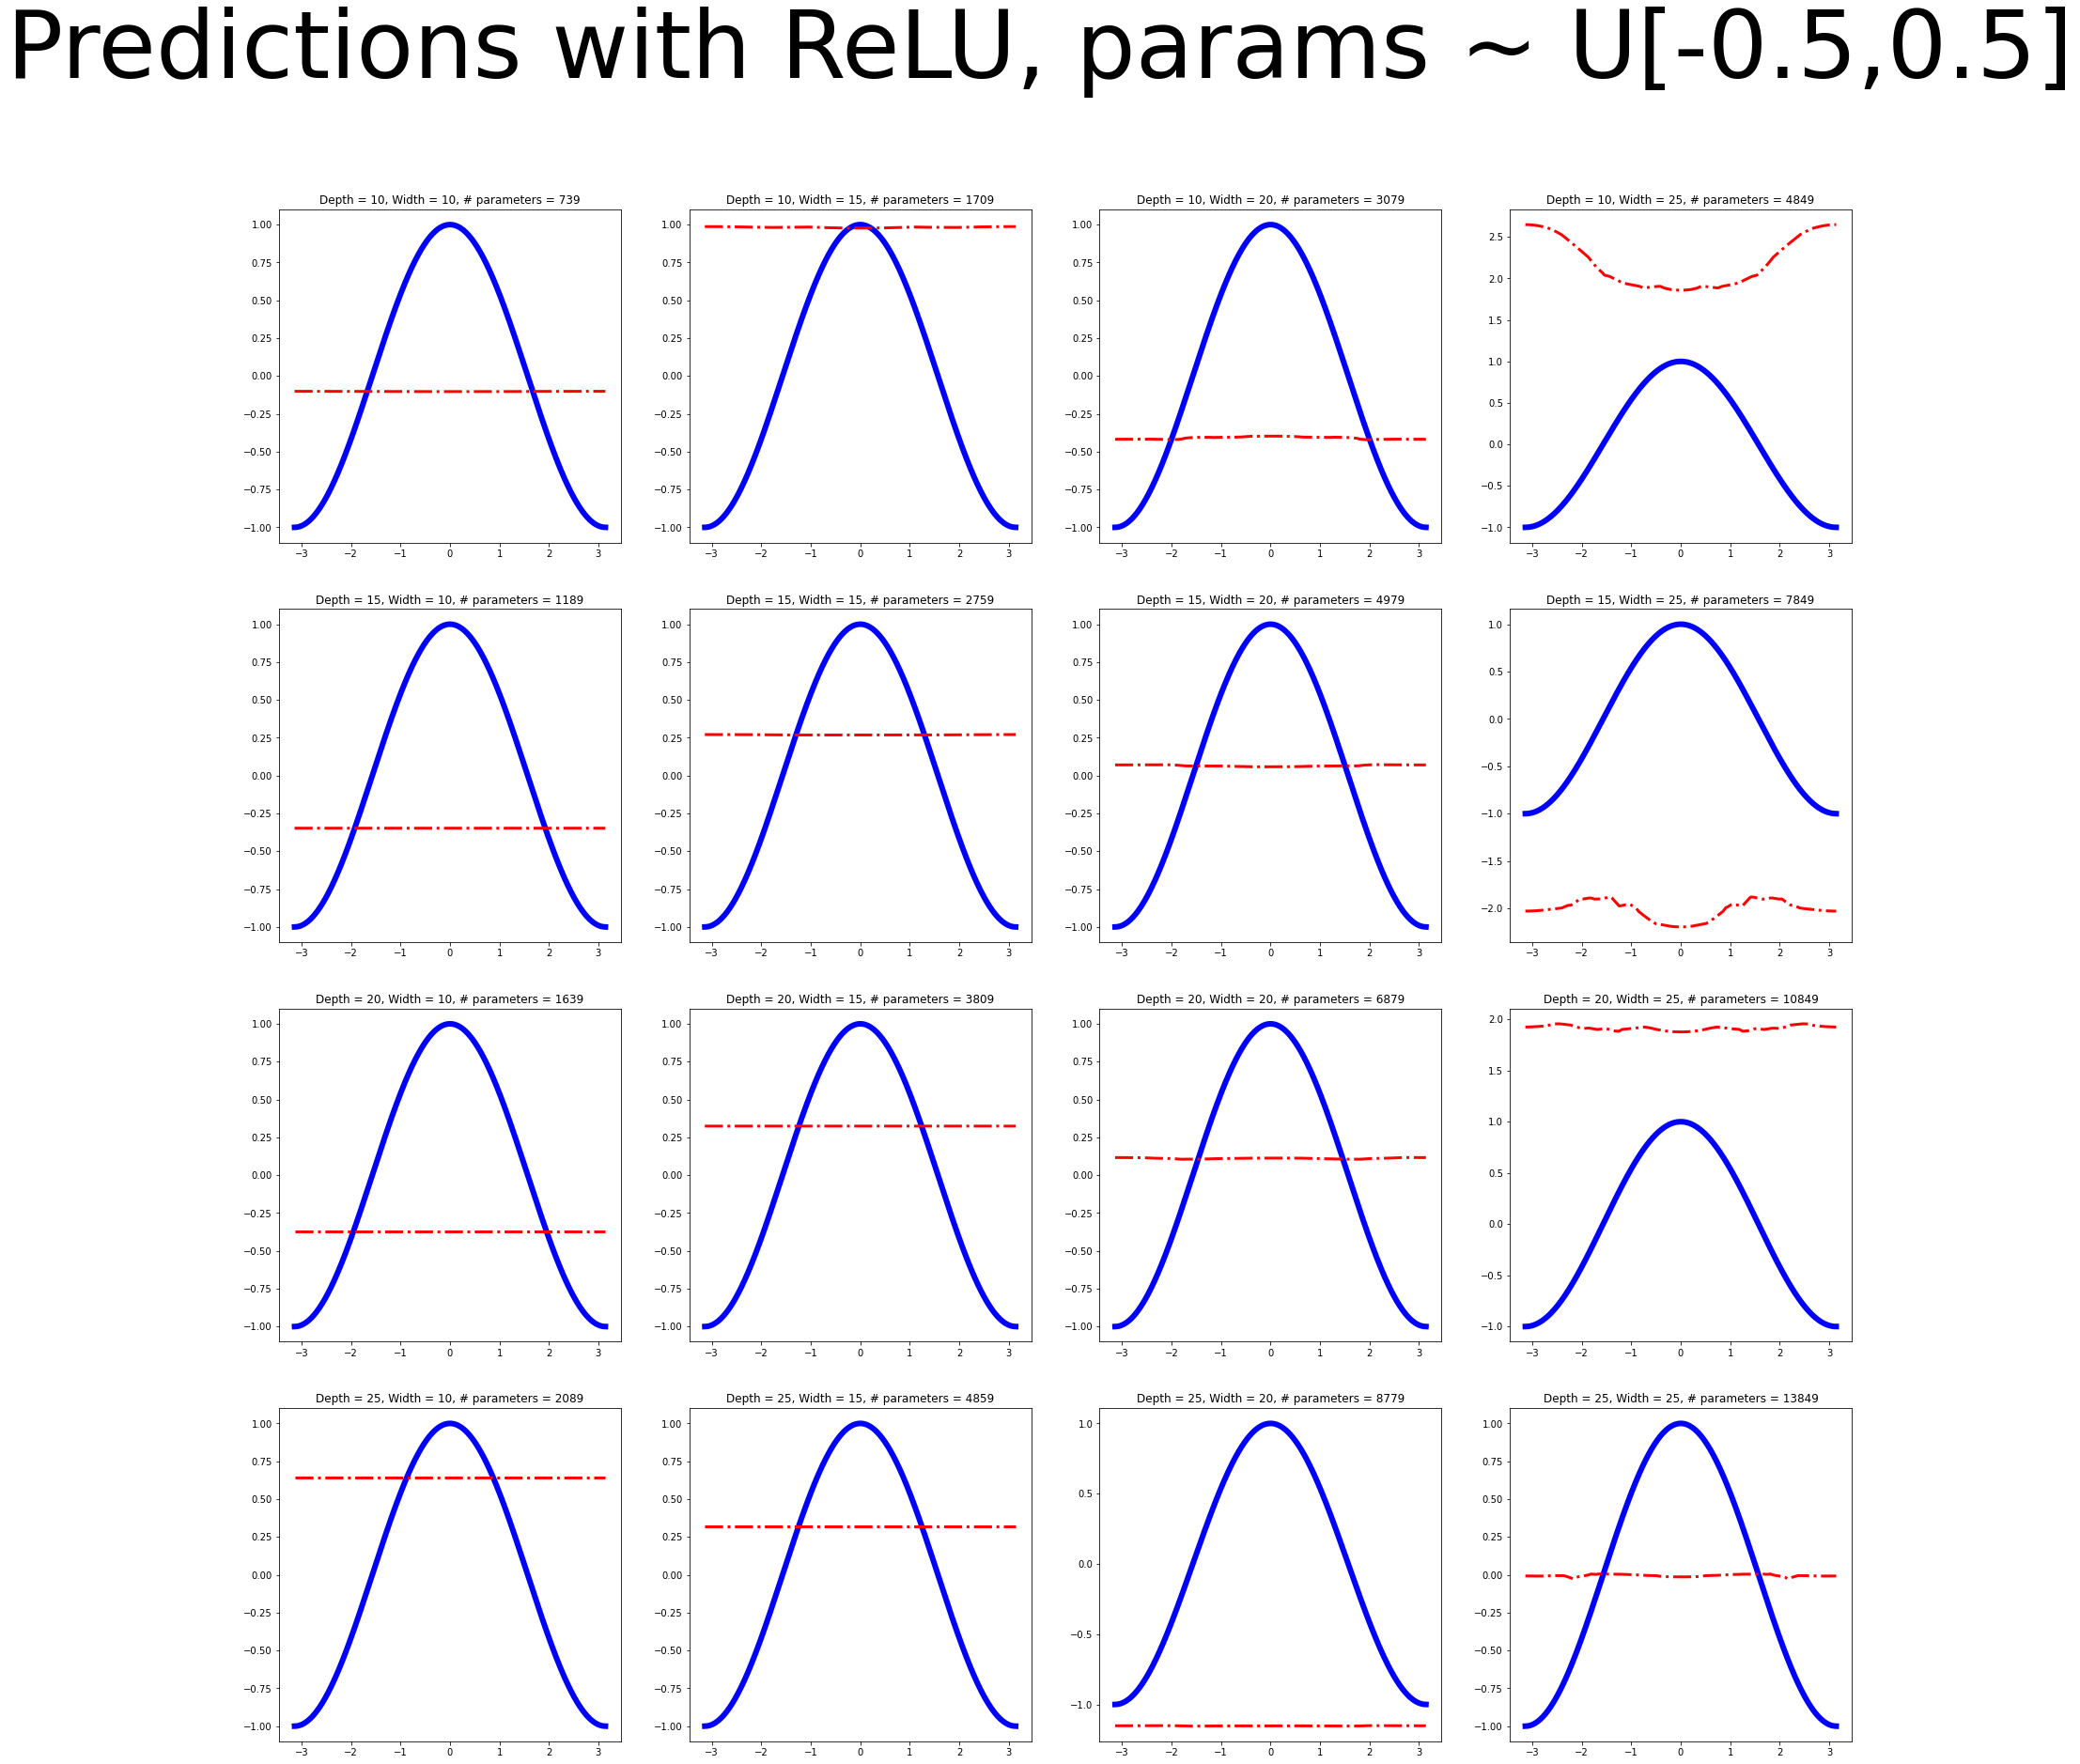

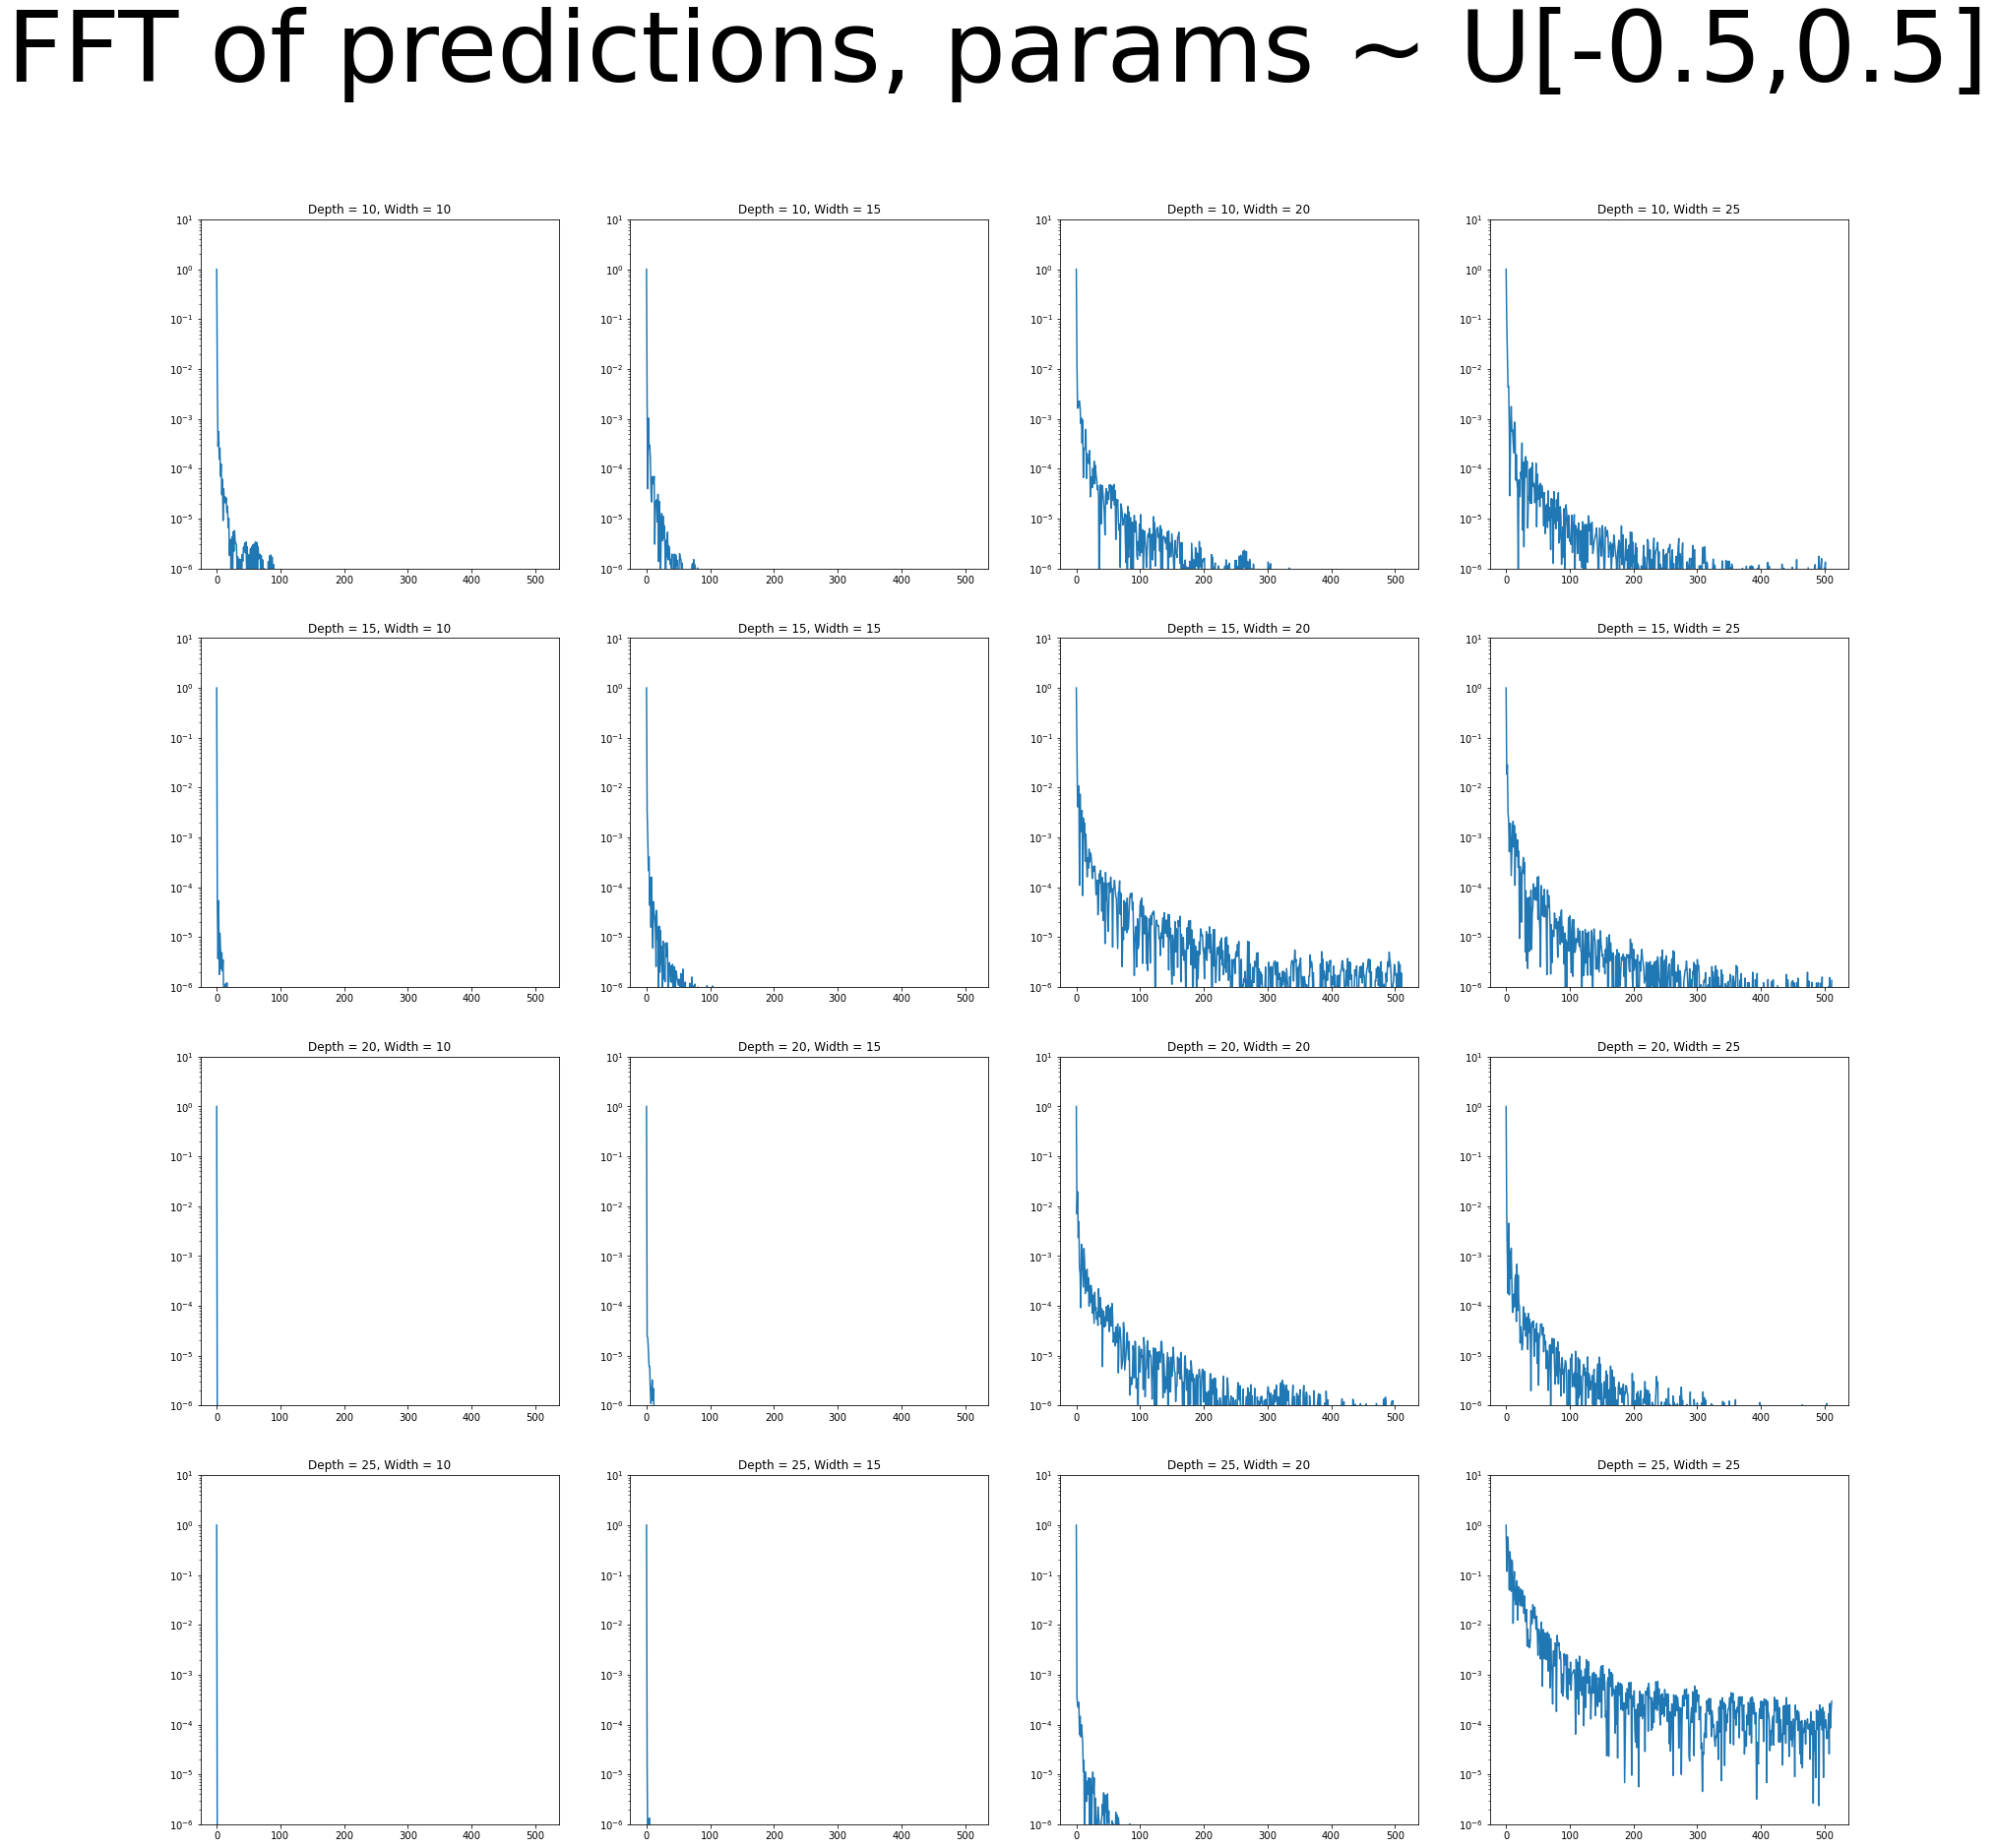

In [46]:
fig1, axs1 = plt.subplots(4, 4, figsize=(30,30))
fig2, axs2 = plt.subplots(4, 4, figsize=(30,30))

fig1.suptitle('Predictions with ReLU, params ~ U[-0.5,0.5]', fontsize=100)
fig2.suptitle('FFT of predictions, params ~ U[-0.5,0.5]', fontsize=100)

for i, width in enumerate(width_list):
    for j, depth in enumerate(depth_list):

        model = DNN2(input_dim=1, output_dim=1, width=width, depth=depth, activation=torch.nn.ReLU(), param_range=0.5)
        model.init_weights()

        with torch.no_grad():
            y_pred = model(x).flatten()
                    
        total_params = compute_num_params(1, 1, width, depth)
        axs1[j, i].plot(theta, x, "b", linewidth=6, label='Actual')
        axs1[j, i].plot(theta, y_pred, "-.", linewidth=3, color="red", label='Predicted')
        axs1[j, i].set_title('Depth = {}, Width = {}, # parameters = {}'.format(depth, width, total_params))
        
        N = len(y_pred)
        yf = np.fft.fft(np.array(y_pred))
        axs2[j, i].plot(np.abs(yf[:N//2])/np.abs(yf[0]))
        axs2[j, i].set_yscale('log')
        axs2[j, i].set_ylim((10**-6,10**1))
        axs2[j, i].set_title('Depth = {}, Width = {}'.format(depth, width))
        
plt.show()

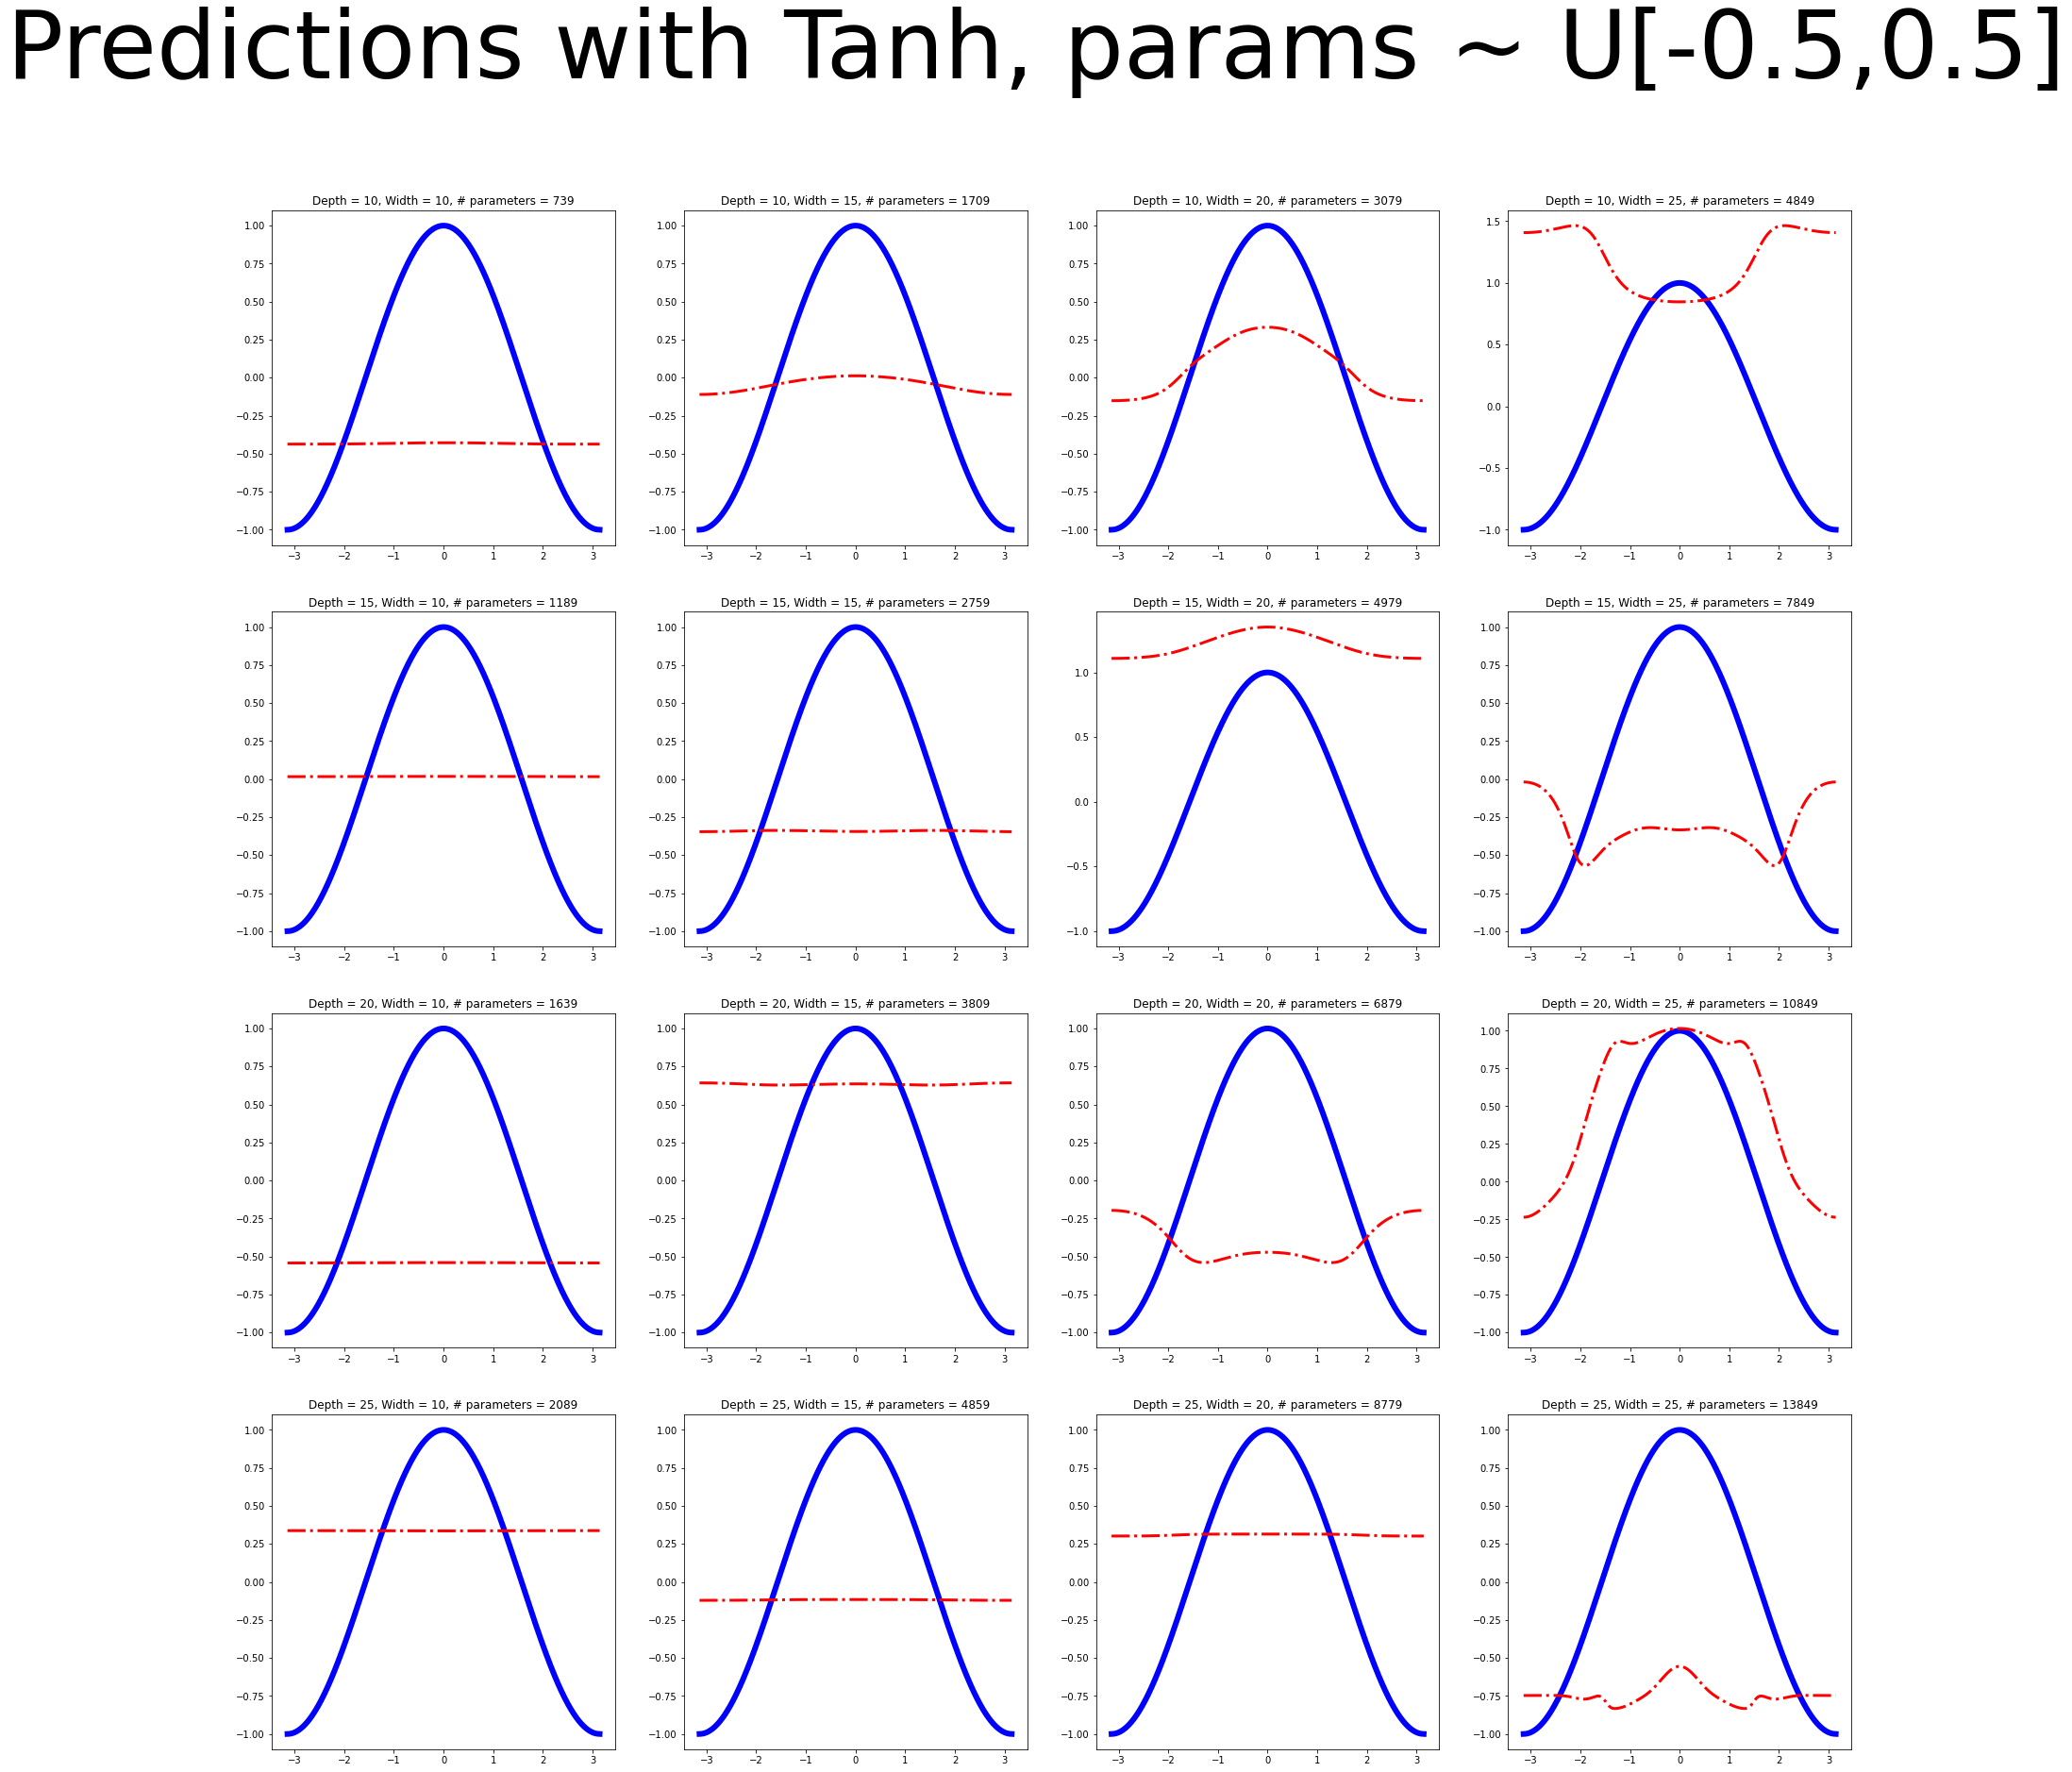

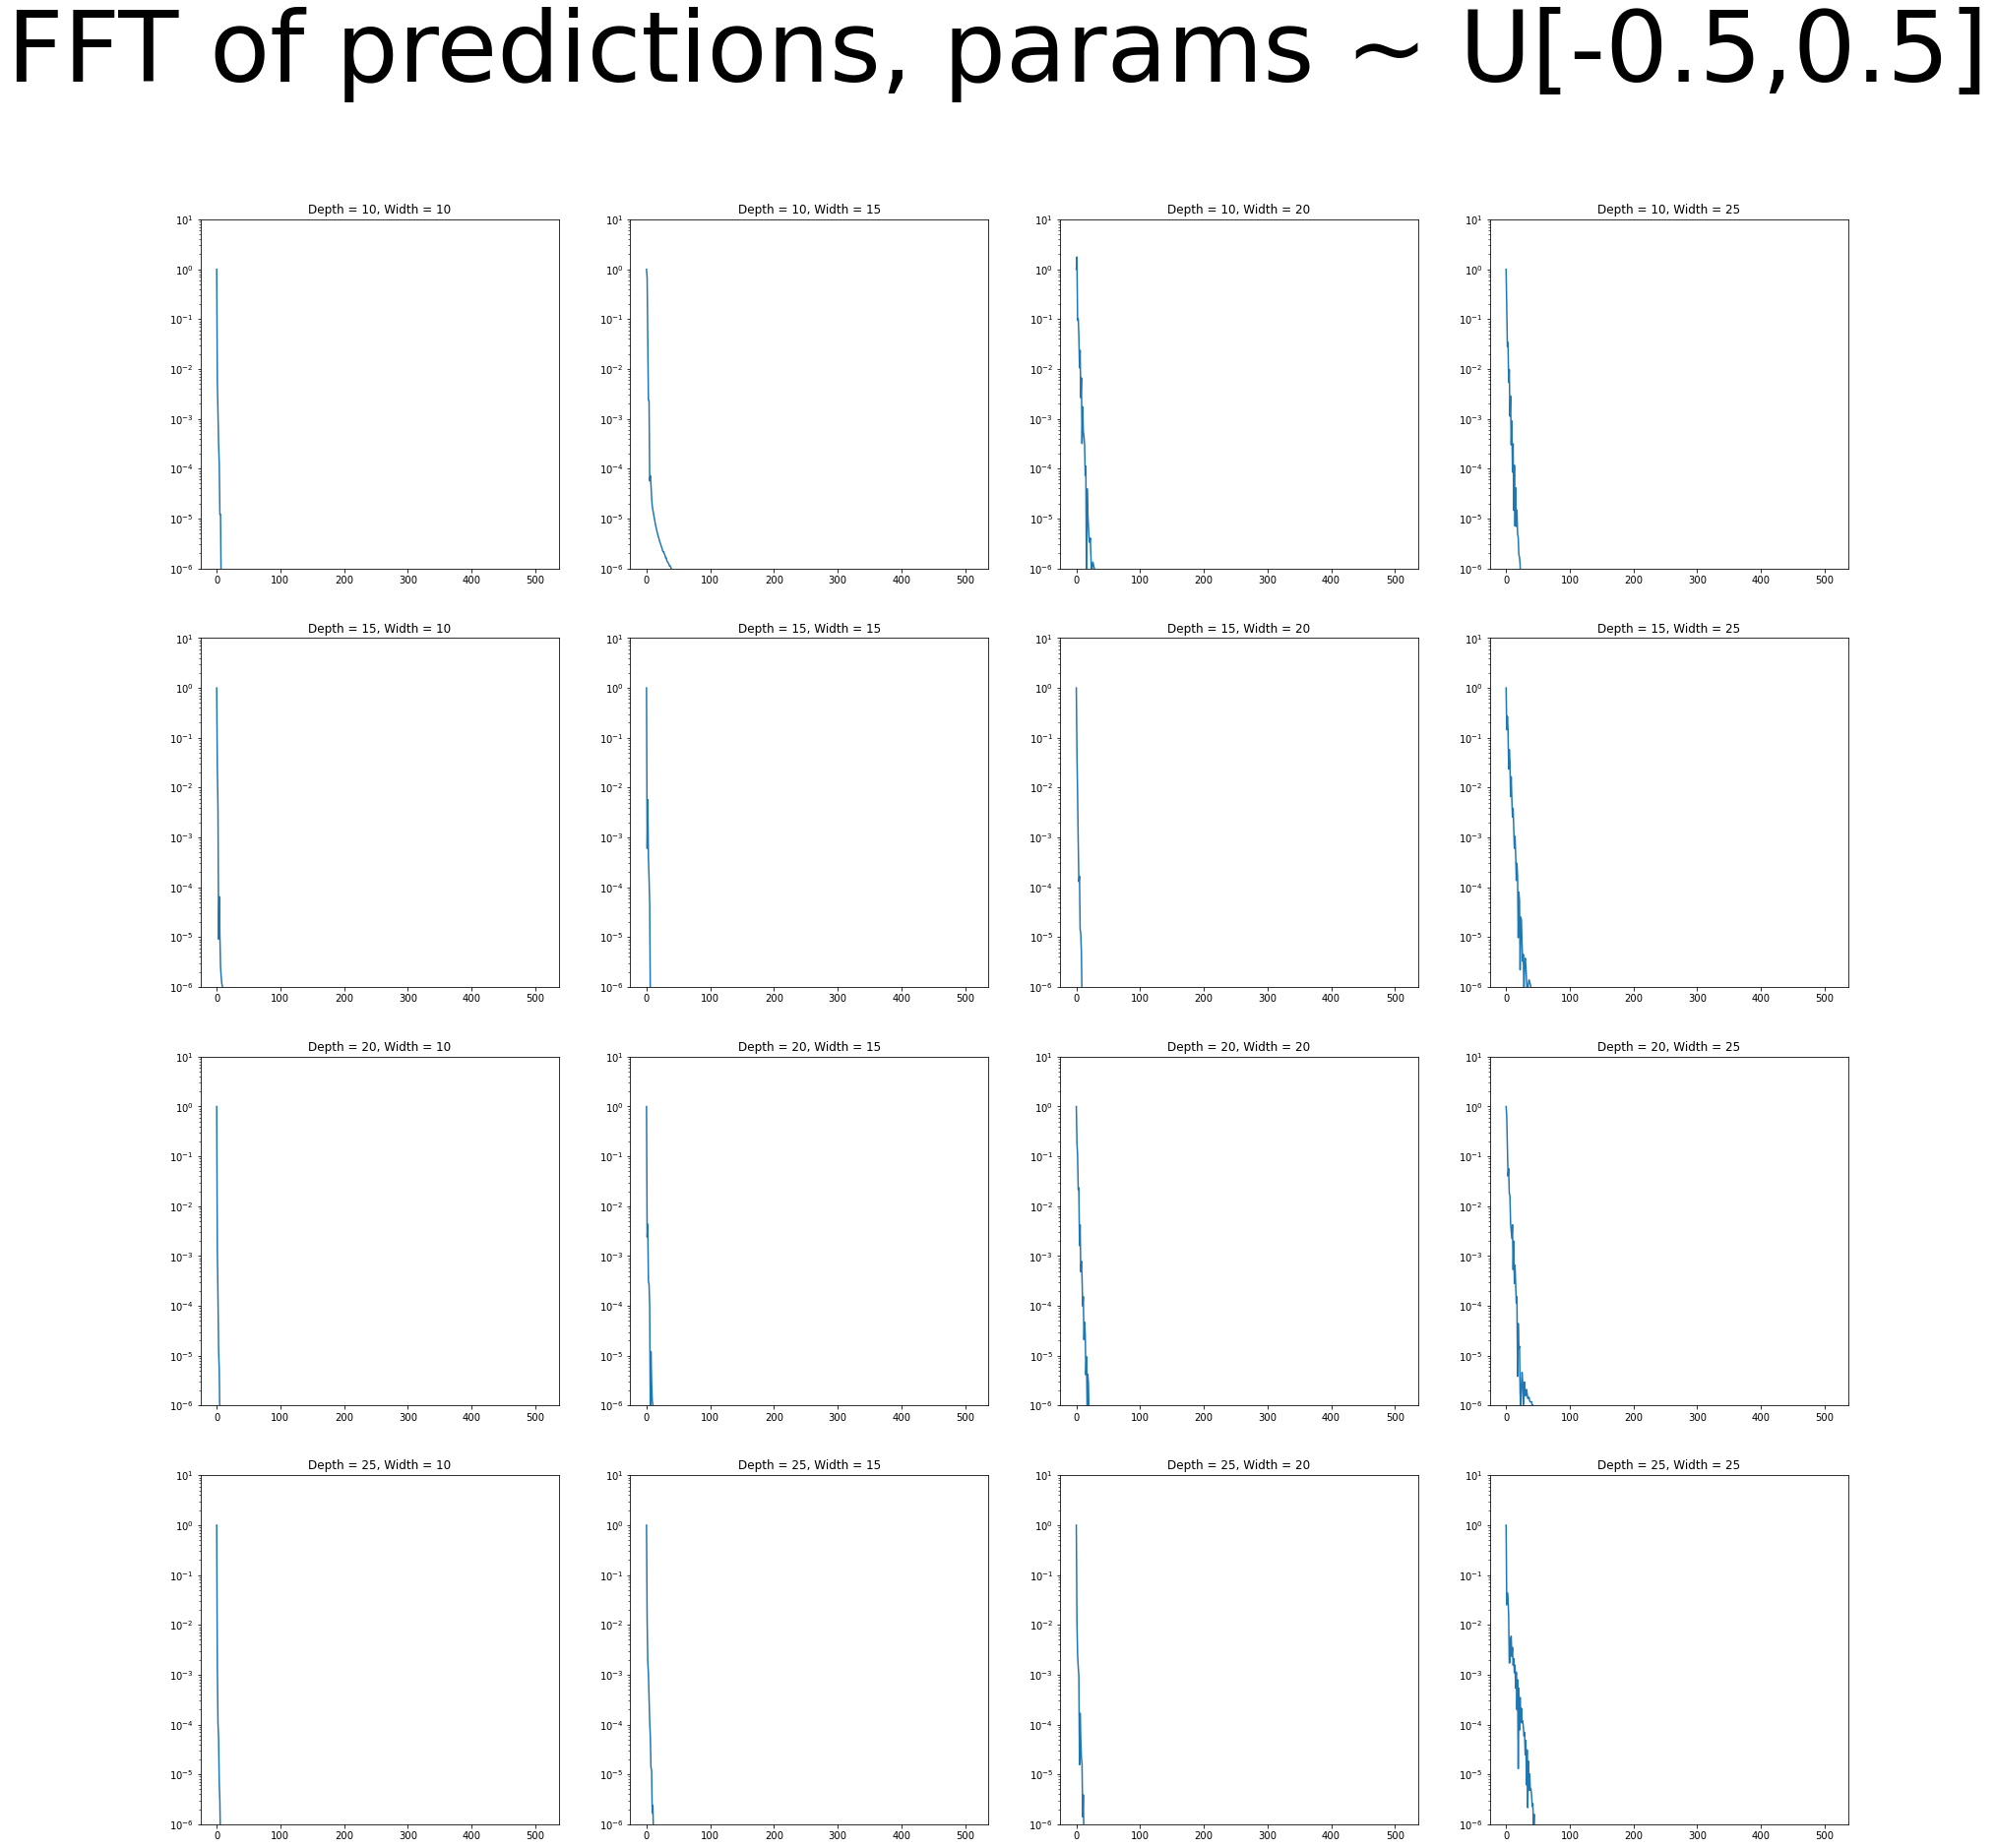

In [47]:
fig1, axs1 = plt.subplots(4, 4, figsize=(30,30))
fig2, axs2 = plt.subplots(4, 4, figsize=(30,30))

fig1.suptitle('Predictions with Tanh, params ~ U[-0.5,0.5]', fontsize=100)
fig2.suptitle('FFT of predictions, params ~ U[-0.5,0.5]', fontsize=100)

for i, width in enumerate(width_list):
    for j, depth in enumerate(depth_list):

        model = DNN2(input_dim=1, output_dim=1, width=width, depth=depth, activation=torch.nn.Tanh(), param_range=0.5)
        model.init_weights()

        with torch.no_grad():
            y_pred = model(x).flatten()
                    
        total_params = compute_num_params(1, 1, width, depth)
        axs1[j, i].plot(theta, x, "b", linewidth=6, label='Actual')
        axs1[j, i].plot(theta, y_pred, "-.", linewidth=3, color="red", label='Predicted')
        axs1[j, i].set_title('Depth = {}, Width = {}, # parameters = {}'.format(depth, width, total_params))
        
        N = len(y_pred)
        yf = np.fft.fft(np.array(y_pred))
        axs2[j, i].plot(np.abs(yf[:N//2])/np.abs(yf[0]))
        axs2[j, i].set_yscale('log')
        axs2[j, i].set_ylim((10**-6,10**1))
        axs2[j, i].set_title('Depth = {}, Width = {}'.format(depth, width))
        
plt.show()

# Observations when varying a for parameters ~ U(-a,a)

It can be seen that increasing a to 10 or 3 leads to over-fitting when we use $Tanh()$ as activation function (huge high-frequency oscillations), and brings the $ReLU()$ approximation closer (in range) the the $cos(\theta)$ function. On the other hand, decreasing a to 0.5 highly reduces the oscillations in the approximations for both $ReLU()$ and $Tanh()$ (under-fitting). Therefore, this shows that the choice of initialization for the parameters is very important and can lead to large performance gaps.